# SI 618 WN Project Part I

## Project Title:
> Provide a descriptive working title for your project.

**Game Sales, Popularity, and Achievements: A Comparative Analysis Across Platforms**

## Team Members
> List each team member and include their uniqname

* Yufeng Song (yfsong)
* Ziqi Wang (Venchy)
* Muyu Lin (linmuyu)

## Overview
> Give a high level description of your project

Our project explores key trends in the gaming industry by analyzing data on game sales, player achievements, and platform preferences. We aim to understand how the same game performs across different platforms, how purchasing preferences vary across countries, and how game popularity evolves over time. Additionally, we will investigate the relationship between supported languages and sales, as well as the impact of pricing on game popularity across multiple platforms. By analyzing these factors, we hope to uncover insights into player behavior, market trends, and factors influencing game success.

## Motivation
> Explain why you chose this particular topic for your project.	Include the three "real-world" questions that you generated about the data, and be sure to explain what you hope to learn by answering them.

We chose this topic because gaming is a massive industry with a highly diverse audience, and understanding player preferences and market trends can provide valuable insights for developers, publishers, and gaming communities. Our project aims to answer the following real-world questions:

1. **How do game genres, game pricing, and in-game achievements differ across platforms for the same game?**

  - By analyzing achievement data, we aim to understand whether players engage with a game differently depending on the platform they use. This could reveal differences in play styles, game difficulty adjustments, or platform-specific engagement trends.

2. **How do game purchase preferences vary by country?**

  - We seek to determine whether purchasing behaviors differ based on regional preferences. Understanding this can help developers tailor their marketing strategies and optimize game pricing for different audiences.

3. **How has the popularity of different game types changed over time (`release_date`)?**

  - By tracking shifts in game genre popularity over time, we hope to uncover trends that indicate the rise and fall of specific genres. This insight could be useful for predicting future market demands and guiding game development strategies.


By answering these questions, we hope to gain a deeper understanding of the gaming landscape, helping stakeholders make data-driven decisions about game development, pricing, and distribution strategies.

## Data Sources
> List the two (or more) sources of data that you'll be using.  Provide URLs where appropriate.	**Explain how the two (or more) datasets complement each other.**

1. https://www.kaggle.com/datasets/artyomkruglov/gaming-profiles-2025-steam-playstation-xbox

2. https://github.com/Smipe-a/gamestatshub

- This Gaming Profiles Data from Kaggle include **game** and **player** data from three different **platforms**, PlayStation, Steam, and Xbox.
- For each platform, the **player** and **game** data is complemented by **achievement** data. The relationships between players, games, and achievements are one-to-many: each player can play multiple games, and each game can have multiple achievements.
- Data from the three platforms can be combined based on **game titles** to analyze shared games across platforms.

## Data Description
> List the variables of interest, the size of the data sets, missing values, etc.

### Common Datasets Across 3 Platforms & Variables of Interest:

#### Player Metadata
- **players.csv**: platform-specific `playerid` and `country` (Xbox data lacks country column)
- **purchased_games.csv** lists players' purchased games, with:
    - `playerid`
    - `libarary`: a list of games the player bought.
- **history.csv**: when the player unlocked the achievement.
    - `playerid`
    - `achievementid`
    - `date_acquired`

#### Game Metadata
- **games.csv**: game details such as `genres`, `developers`, `publishers`, `supported_language`, and `release_date`.
- **achievements.csv** maps achievements to their respective game, with:
    - `achievementid` combines the uniqe game id on the platform and the achievement id within the game
    - `gameid`
    - `title`
    - `description`
- **prices.csv**: games' price in various currencies, with `date_acquired` indicating the date when the price was recorded.

## Data Manipulation
> Mostly code in this section.  This is where you merge your data sets, as well as create new columns (if appropriate)

#### Merged Datasets Explained - Flattened Table For Raw Analysis
- Platform-Specific Datasets:
    - Player-Info Dataset: merged on `playerid`
    - Game-Info Dataset: merged on `gameid`
- Cross-Platform Game Dataset: merged on game `title` to combine shared game data from all three platforms.

**Notes**: 
- In all the merged datasets, there are duplicated gameid/playerid after merge due to the one-to-many relationship between players, games, and achievements. 
- In the corss-platform game table, there are duplicated game titles across platforms.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## PS

In [2]:
import os

PS_DATA_FOLDER = "data/ps"

dfs = {}

for root, dirs, files in os.walk(PS_DATA_FOLDER):
    for file in files:
        if file.endswith(".csv"):
            file_path = os.path.join(root, file)
            df_name = f"{os.path.basename(root)}_{file.replace('.csv', '')}".replace('.csv', '')  # Clean name
            dfs[df_name] = pd.read_csv(file_path)

for name, df in dfs.items():
    print(f"{name} - shape: {df.shape}")

ps_purchased_games - shape: (46582, 2)
ps_history - shape: (19510083, 3)
ps_prices - shape: (62816, 7)
ps_players - shape: (356600, 3)
ps_games - shape: (23151, 8)
ps_achievements - shape: (846563, 5)


In [3]:
ps_achievements = dfs['ps_achievements']
ps_games = dfs['ps_games']
ps_history = dfs['ps_history']
ps_players = dfs['ps_players']
ps_prices = dfs['ps_prices']
ps_purchased_games = dfs['ps_purchased_games']

# check duplicates
print(ps_games.duplicated(subset=["gameid"]).sum())
print(ps_prices.duplicated(subset=["gameid"]).sum())
print(ps_achievements.duplicated(subset=["achievementid"]).sum())
print(ps_players.duplicated(subset=["playerid"]).sum())
print(ps_purchased_games.duplicated(subset=["playerid"]).sum())

0
32095
0
0
0


In [4]:
ps_prices['gameid'].value_counts()

gameid
726666    3
723091    3
727730    3
727729    3
728792    3
         ..
421567    2
421164    2
421153    2
421368    2
423969    2
Name: count, Length: 30721, dtype: int64

In [5]:
ps_prices[ps_prices['gameid'] == 726666]

,gameid,usd,eur,gbp,jpy,rub,date_acquired
20167,726666,6.99,6.99,5.79,1100.0,NaN,2025-02-22
50835,726666,6.99,6.99,5.79,1100.0,NaN,2025-02-25
52307,726666,6.99,6.99,5.79,1100.0,NaN,2025-02-24


In [6]:
# for each gameid, keep only the most recent price entry
ps_prices = ps_prices.sort_values("date_acquired").drop_duplicates(subset=["gameid"], keep="last")
print(ps_prices.duplicated(subset=["gameid"]).sum())

0


### Player focus

In [7]:
ps_player_info = ps_players.merge(ps_history, on="playerid", how="left")

In [8]:
ps_player_info = ps_player_info.merge(ps_achievements, on="achievementid", how="left")

In [9]:
ps_player_info = ps_player_info.merge(ps_purchased_games, on="playerid", how="left")

In [10]:
ps_player_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19861683 entries, 0 to 19861682
Data columns (total 10 columns):
 #   Column         Dtype  
---  ------         -----  
 0   playerid       int64  
 1   nickname       object 
 2   country        object 
 3   achievementid  object 
 4   date_acquired  object 
 5   gameid         float64
 6   title          object 
 7   description    object 
 8   rarity         object 
 9   library        object 
dtypes: float64(1), int64(1), object(8)
memory usage: 1.5+ GB


In [11]:
ps_player_info.sample(5)

,playerid,nickname,country,achievementid,date_acquired,gameid,title,description,rarity,library
2063393,331563,TrannosaurusBex,United Kingdom,17658_174352,2019-10-18 09:38:36,17658.0,Eagle-eyed,Finish any Hidden Object Puzzle in less than 1...,Bronze,"[637403, 589203, 622669, 440433, 137118, 42261..."
18140595,3135196,gadtrololoYT,Ukraine,555458_4645772,2023-08-22 01:02:37,555458.0,Come On!,Got hit while performing a taunt.,Bronze,"[734891, 706747, 417808, 647032, 463264, 49271..."
1531240,361899,PureRuby87,Italy,512565_4419814,2023-01-27 17:21:20,512565.0,I Don't Feel So Good,Leave the clock tower plaza.,Bronze,"[660181, 660084, 755109, 550476, 702561, 41815..."
899933,318566,hira-meteo,Japan,523782_4479988,2023-12-09 19:20:48,523782.0,Collect 1 coin,Collect 1 coin,Gold,"[711383, 177577, 8696, 637991, 638410, 727624,..."
16723975,3257921,kid-nee,Australia,626608_5147684,2024-04-15 13:44:16,626608.0,Nerrrd,Achieve an A Grade in a Training Drill in Care...,Silver,"[626608, 456160, 9481, 417812, 6543, 417778, 4..."


### Game focus
date_acquired column is dropped as it indicates the timestamp when the price info was extracted from multiple databases and do not add helpful insights to our analysis.

In [12]:
ps_game_info = ps_games.merge(ps_achievements.rename(columns={'title': 'achievement_title'}), on="gameid", how="left")

In [13]:
ps_game_info = ps_game_info.merge(ps_prices, on="gameid", how="left")

In [14]:
ps_game_info = ps_game_info.drop(columns=['date_acquired'])

In [15]:
ps_game_info.rename(columns={'platform': 'PS_platform'}, inplace=True)

In [16]:
ps_game_info.rename(columns={'description': 'achievement_description'}, inplace=True)

In [17]:
ps_game_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626958 entries, 0 to 626957
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   gameid                   626958 non-null  int64  
 1   title                    626958 non-null  object 
 2   PS_platform              626958 non-null  object 
 3   developers               626416 non-null  object 
 4   publishers               626624 non-null  object 
 5   genres                   623044 non-null  object 
 6   supported_languages      319860 non-null  object 
 7   release_date             626958 non-null  object 
 8   achievementid            626958 non-null  object 
 9   achievement_title        626954 non-null  object 
 10  achievement_description  626942 non-null  object 
 11  rarity                   626958 non-null  object 
 12  usd                      535794 non-null  float64
 13  eur                      508924 non-null  float64
 14  gbp 

PS-only cols: rarity, PS_platform

In [18]:
ps_game_info.sample(5)

,gameid,title,PS_platform,developers,publishers,genres,supported_languages,release_date,achievementid,achievement_title,achievement_description,rarity,usd,eur,gbp,jpy,rub
177361,424611,Project Starship X,PS4,['Panda Indie Studio'],['Panda Indie Studio'],['Indie'],NaN,2021-01-27,424611_3852781,Boss Killer Lvl 1,Kill 1 boss in a single playthrough,Silver,9.99,9.99,7.99,499.0,NaN
136697,500217,Ammo Pigs: Cocked and Loaded,PS4,"['Cascadia Games', 'ChiliDog Interactive']",['ESDigital Games'],['Run & Gun'],NaN,2022-02-11,500217_4361497,Negligence towards chickens,Let 10 chickens die,Silver,4.99,4.99,3.99,660.0,NaN
127734,522125,Sword and Fairy: Together Forever,PS5,['SOFTSTAR Entertainment'],"['eastasiasoft', 'Game Source Entertainment']","['Action-RPG', 'Role Playing']","['Japanese', 'Chinese (traditional)', 'Chinese...",2022-08-04,522125_4469535,Thanks For Your Test,Defeat the Spirit Ice Beast,Bronze,39.99,39.99,34.99,NaN,NaN
231789,174768,Serious Sam Collection,PS4,['Croteam'],['Devolver Digital'],"['First Person Shooter', 'Third Person Shooter...","['French', 'Spanish', 'German', 'Italian', 'Ru...",2020-11-17,174768_2955243,"Look Ma, I'm a Lumberjack!",Cut down some trees.,Bronze,5.99,5.99,4.99,NaN,NaN
429723,630410,Double Dragon Advance,PS4,['Arc System Works'],['Arc System Works'],"[""Beat 'em up""]","['Japanese', 'French', 'Spanish', 'German', 'I...",2023-11-09,630410_5176568,"Normal, Complete!",View the ending on Normal difficulty.,Gold,3.49,3.24,2.67,NaN,NaN


In [19]:
ps_game_info['achievementid'].value_counts()

achievementid
749375_6098396    1
650405_5312282    1
650406_5312373    1
650406_5312374    1
650406_5312375    1
                 ..
336965_3248824    1
336965_3248825    1
336965_3248826    1
336965_3248827    1
7593_93460        1
Name: count, Length: 626958, dtype: int64

## Steam

In [20]:
import os
import pandas as pd

STEAM_DATA_FOLDER = "data/steam"

dfs = {}

for root, dirs, files in os.walk(STEAM_DATA_FOLDER):
    for file in files:
        if file.endswith(".csv"):
            file_path = os.path.join(root, file)
            df_name = f"{os.path.basename(root)}_{file.replace('.csv', '')}".replace('.csv', '')  # Clean name
            dfs[df_name] = pd.read_csv(file_path)

for name, df in dfs.items():
    print(f"{name} - shape: {df.shape}")


steam_purchased_games - shape: (102548, 2)
steam_reviews - shape: (1204534, 8)
steam_history - shape: (10693879, 3)
steam_friends - shape: (424683, 2)
steam_prices - shape: (4414273, 7)
steam_players - shape: (424683, 3)
steam_games - shape: (98248, 7)
steam_private_steamids - shape: (227963, 1)
steam_achievements - shape: (1939027, 4)


In [21]:
steam_achievements = dfs['steam_achievements']
steam_games = dfs['steam_games']
steam_history = dfs['steam_history']
steam_players = dfs['steam_players']
steam_prices = dfs['steam_prices']
steam_purchased_games = dfs['steam_purchased_games']

# check duplicates
print(steam_games.duplicated(subset=["gameid"]).sum())
print(steam_prices.duplicated(subset=["gameid"]).sum())
print(steam_achievements.duplicated(subset=["achievementid"]).sum())
print(steam_players.duplicated(subset=["playerid"]).sum())
print(steam_purchased_games.duplicated(subset=["playerid"]).sum())

0
4315808
0
0
0


In [22]:
# for each gameid, keep only the most recent price entry
steam_prices = steam_prices.sort_values("date_acquired").drop_duplicates(subset=["gameid"], keep="last")
print(steam_prices.duplicated(subset=["gameid"]).sum())

0


### Player focus

In [23]:
st_player_info = steam_players.merge(steam_history, on="playerid", how="left")

In [24]:
st_player_info = st_player_info.merge(steam_achievements, on="achievementid", how="left")

In [25]:
st_player_info = st_player_info.merge(steam_purchased_games, on="playerid", how="left")

# # Save player-focused data
# steam_player_info.to_csv('data/steam_players.csv', index=False)

In [26]:
st_player_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11113724 entries, 0 to 11113723
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   playerid       int64  
 1   country        object 
 2   created        object 
 3   achievementid  object 
 4   date_acquired  object 
 5   gameid         float64
 6   title          object 
 7   description    object 
 8   library        object 
dtypes: float64(1), int64(1), object(7)
memory usage: 763.1+ MB


In [27]:
st_player_info.shape

(11113724, 9)

In [28]:
st_player_info.head(5)

,playerid,country,created,achievementid,date_acquired,gameid,title,description,library
0,76561198287452552,Brazil,2016-03-02 06:14:20,NaN,NaN,NaN,NaN,NaN,"[10, 80, 100, 240, 2990, 6880, 6910, 6920, 698..."
1,76561198040436563,Israel,2011-04-10 17:10:06,NaN,NaN,NaN,NaN,NaN,"[10, 80, 100, 300, 20, 30, 40, 50, 60, 70, 130..."
2,76561198049686270,NaN,2011-09-28 21:43:59,NaN,NaN,NaN,NaN,NaN,NaN
3,76561198155814250,Kazakhstan,2014-09-24 19:52:47,NaN,NaN,NaN,NaN,NaN,NaN
4,76561198119605821,NaN,2013-12-26 00:25:50,NaN,NaN,NaN,NaN,NaN,"[47870, 108600, 550, 271590, 331470, 381210, 2..."


### Game focus

In [29]:
st_game_info = steam_games.merge(steam_achievements.rename(columns={'title': 'achievement_title'}), on="gameid", how="left")

In [30]:
st_game_info = st_game_info.merge(steam_prices, on="gameid", how="left")

In [31]:
st_game_info = st_game_info.drop(columns=['date_acquired'])

In [32]:
st_game_info.rename(columns={'description': 'achievement_description'}, inplace=True)

In [33]:
st_game_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1983659 entries, 0 to 1983658
Data columns (total 15 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   gameid                   int64  
 1   title                    object 
 2   developers               object 
 3   publishers               object 
 4   genres                   object 
 5   supported_languages      object 
 6   release_date             object 
 7   achievementid            object 
 8   achievement_title        object 
 9   achievement_description  object 
 10  usd                      float64
 11  eur                      float64
 12  gbp                      float64
 13  jpy                      float64
 14  rub                      float64
dtypes: float64(5), int64(1), object(9)
memory usage: 227.0+ MB


In [34]:
st_game_info.shape

(1983659, 15)

In [35]:
st_game_info['achievementid'].value_counts()

achievementid
3266470_ACHIEVEMENT_5_MINUTES    1
2578790_Liquidator               1
2578790_Space_Rebel              1
2578790_Slugger                  1
2578790_Sergeant                 1
                                ..
1098080_ACHIEVEMENT_9            1
1098080_ACHIEVEMENT_8            1
1098080_ACHIEVEMENT_7            1
1098080_ACHIEVEMENT_6            1
1499240_ROMANROCKS               1
Name: count, Length: 1935882, dtype: int64

## XBOX

In [36]:
import os
import pandas as pd

XBOX_DATA_FOLDER = "data/xbox"

dfs = {}

for root, dirs, files in os.walk(XBOX_DATA_FOLDER):
    for file in files:
        if file.endswith(".csv"):
            file_path = os.path.join(root, file)
            df_name = f"{os.path.basename(root)}_{file.replace('.csv', '')}".replace('.csv', '')
            dfs[df_name] = pd.read_csv(file_path)

for name, df in dfs.items():
    print(f"{name} - shape: {df.shape}")


xbox_purchased_games - shape: (46466, 2)
xbox_history - shape: (15275900, 3)
xbox_prices - shape: (22638, 7)
xbox_players - shape: (274450, 2)
xbox_games - shape: (10489, 7)
xbox_achievements - shape: (351111, 5)


In [37]:
xbox_achievements = dfs['xbox_achievements']
xbox_games = dfs['xbox_games']
xbox_history = dfs['xbox_history']
xbox_players = dfs['xbox_players']
xbox_prices = dfs['xbox_prices']
xbox_purchased_games = dfs['xbox_purchased_games']

# check duplicates
print(xbox_games.duplicated(subset=["gameid"]).sum())
print(xbox_prices.duplicated(subset=["gameid"]).sum())
print(xbox_achievements.duplicated(subset=["achievementid"]).sum())
print(xbox_players.duplicated(subset=["playerid"]).sum())
print(xbox_purchased_games.duplicated(subset=["playerid"]).sum())

0
11319
0
0
0


In [38]:
# for each gameid, keep only the most recent price entry
xbox_prices = xbox_prices.sort_values("date_acquired").drop_duplicates(subset=["gameid"], keep="last")
print(xbox_prices.duplicated(subset=["gameid"]).sum())

0


### Player focus

In [39]:
xb_player_info = xbox_players.merge(xbox_history, on="playerid", how="left")

In [40]:
xb_player_info = xb_player_info.merge(xbox_achievements, on="achievementid", how="left")

In [41]:
xb_player_info = xb_player_info.merge(xbox_purchased_games, on="playerid", how="left")

In [42]:
xb_player_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15545366 entries, 0 to 15545365
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   playerid       int64  
 1   nickname       object 
 2   achievementid  object 
 3   date_acquired  object 
 4   gameid         float64
 5   title          object 
 6   description    object 
 7   points         float64
 8   library        object 
dtypes: float64(2), int64(1), object(6)
memory usage: 1.0+ GB


In [43]:
xb_player_info.shape

(15545366, 9)

In [46]:
xb_player_info.sample(10)

,playerid,nickname,achievementid,date_acquired,gameid,title,description,points,library
5253066,845962,akanesign,4919_335531,2013-05-19 17:18:45,4919.0,哀哭する魂,episode0-2終了,10.0,"[748479, 9118, 370513, 648341, 701729, 693001,..."
10821895,2102219,SprayElegant,7646_352795,2018-03-01 22:51:42,7646.0,Well-Read,Discover a veilfire rune.,15.0,"[702075, 19405, 693001, 8901, 657063, 616624, ..."
4235290,1221578,IAmTheDude360,464880_4183996,2023-04-07 00:46:56,464880.0,Two Sides to Every Story,Accessed your first Banished Audio Log.,10.0,"[693001, 694722, 593742, 550303, 589201, 56324..."
10959795,813490,MilkmanSAW,1192_266340,2010-11-07 16:04:53,1192.0,Total Protonic Reversal,Knock yourself down with your own weapon.,5.0,"[24405, 14312, 646081, 183493, 9613, 26620, 46..."
7036782,845063,El Griff84,1365_271250,2009-06-10 15:44:23,1365.0,Whammy Mania,Use the Whammy Bar on every held note on Numbe...,15.0,"[459919, 11501, 556004, 26620, 421338, 20701, ..."
9793670,782176,Sh4DoWDualSp,557191_4661207,2023-07-04 03:21:02,557191.0,Chew 'Em Up,Kill ten enemies with environmental hazards,30.0,"[589201, 550303, 421362, 8901, 12144, 601335, ..."
7488173,832351,Alexus I,589011_4878514,2023-04-24 01:20:01,589011.0,Tender Soul,The case is deeper than he thought...,25.0,"[756452, 511842, 755120, 191727, 526464, 45971..."
14708237,667630,veKtik,1159_265138,2012-09-22 20:05:57,1159.0,Elevate Your Senses!,With regards from Group 935,25.0,"[9637, 17042, 135220, 614704, 11501, 492718, 1..."
7800445,828672,dbqpdb,406825_3709392,2020-08-27 03:19:35,406825.0,Brawling… With Style!,Earned your first 'S' Rank from an encounter.,15.0,"[167710, 463487, 676828, 1200, 1615, 184997, 5..."
14036180,742586,ElkeSchwitzt,14312_380991,2016-11-30 18:32:33,14312.0,First Time Buyer,Visit the Autoshow and buy your first car.,10.0,"[606786, 463211, 557295, 492718, 7756, 458216,..."


### Game focus

In [47]:
xb_game_info = xbox_games.merge(xbox_achievements.rename(columns={'title': 'achievement_title'}), on="gameid", how="left")

In [48]:
xb_game_info = xb_game_info.merge(xbox_prices, on="gameid", how="left")

In [49]:
xb_game_info = xb_game_info.drop(columns=['date_acquired', 'points'])

In [50]:
xb_game_info.rename(columns={'description': 'achievement_description'}, inplace=True)

In [51]:
xb_game_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323038 entries, 0 to 323037
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   gameid                   323038 non-null  int64  
 1   title                    323038 non-null  object 
 2   developers               304402 non-null  object 
 3   publishers               305059 non-null  object 
 4   genres                   304168 non-null  object 
 5   supported_languages      132805 non-null  object 
 6   release_date             323038 non-null  object 
 7   achievementid            323038 non-null  object 
 8   achievement_title        323037 non-null  object 
 9   achievement_description  322984 non-null  object 
 10  usd                      237247 non-null  float64
 11  eur                      226837 non-null  float64
 12  gbp                      234618 non-null  float64
 13  jpy                      0 non-null       float64
 14  rub 

## Game Info Across Platforms

In [52]:
len(ps_game_info['gameid'].unique())

23151

In [53]:
len(st_game_info['gameid'].unique())

98248

In [54]:
len(xb_game_info['gameid'].unique())

10489

In [55]:
ps_titles = set(ps_game_info['title'].str.lower().str.strip())
st_titles = set(st_game_info['title'].str.lower().str.strip())
xb_titles = set(xb_game_info['title'].str.lower().str.strip())

shared_ps_st = ps_titles.intersection(st_titles)
shared_ps_xb = ps_titles.intersection(xb_titles)
shared_st_xb = st_titles.intersection(xb_titles)
shared_all = ps_titles.intersection(st_titles, xb_titles)

print(f"Shared titles between PS & ST: {len(shared_ps_st)}")
print(f"Shared titles between PS & XB: {len(shared_ps_xb)}")
print(f"Shared titles between ST & XB: {len(shared_st_xb)}")
print(f"Shared across all three: {len(shared_all)}")


Shared titles between PS & ST: 5571
Shared titles between PS & XB: 5360
Shared titles between ST & XB: 5540
Shared across all three: 3815


In [56]:
def clean_game_info(df, platform):
    df = df.copy()
    
    # drop platform-specific columns (ps_game_info's 'rarity' and 'PS_platform')
    drop_cols = ['date_acquired', 'rarity', 'PS_platform']
    df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')

    # add platform column
    df['platform'] = platform
    
    return df

In [57]:
ps_game_info_clean = clean_game_info(ps_game_info, 'ps')

In [58]:
ps_game_info_clean.columns

Index(['gameid', 'title', 'developers', 'publishers', 'genres',
       'supported_languages', 'release_date', 'achievementid',
       'achievement_title', 'achievement_description', 'usd', 'eur', 'gbp',
       'jpy', 'rub', 'platform'],
      dtype='object')

In [59]:
st_game_info_clean = clean_game_info(st_game_info, 'st')

In [60]:
st_game_info_clean.columns

Index(['gameid', 'title', 'developers', 'publishers', 'genres',
       'supported_languages', 'release_date', 'achievementid',
       'achievement_title', 'achievement_description', 'usd', 'eur', 'gbp',
       'jpy', 'rub', 'platform'],
      dtype='object')

In [61]:
xb_game_info_clean = clean_game_info(xb_game_info, 'xb')

In [62]:
xb_game_info_clean.columns

Index(['gameid', 'title', 'developers', 'publishers', 'genres',
       'supported_languages', 'release_date', 'achievementid',
       'achievement_title', 'achievement_description', 'usd', 'eur', 'gbp',
       'jpy', 'rub', 'platform'],
      dtype='object')

In [63]:
shared_games = set(ps_game_info_clean['title']) & set(st_game_info_clean['title']) & set(xb_game_info_clean['title'])

ps_game_info_clean = ps_game_info_clean[ps_game_info_clean['title'].isin(shared_games)]
st_game_info_clean = st_game_info_clean[st_game_info_clean['title'].isin(shared_games)]
xb_game_info_clean = xb_game_info_clean[xb_game_info_clean['title'].isin(shared_games)]

merged_game_info = pd.concat([ps_game_info_clean, st_game_info_clean, xb_game_info_clean], ignore_index=True)

print(f"Merged dataset shape: {merged_game_info.shape}")

Merged dataset shape: (431985, 16)


In [64]:
merged_game_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431985 entries, 0 to 431984
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   gameid                   431985 non-null  int64  
 1   title                    431985 non-null  object 
 2   developers               430744 non-null  object 
 3   publishers               430459 non-null  object 
 4   genres                   430507 non-null  object 
 5   supported_languages      274284 non-null  object 
 6   release_date             431985 non-null  object 
 7   achievementid            431807 non-null  object 
 8   achievement_title        431801 non-null  object 
 9   achievement_description  414137 non-null  object 
 10  usd                      398232 non-null  float64
 11  eur                      386835 non-null  float64
 12  gbp                      396497 non-null  float64
 13  jpy                      186153 non-null  float64
 14  rub 

In [65]:
merged_game_info['achievementid'].value_counts()

achievementid
749591_6100112             1
384010_PIECE_OF_CAKE       1
384180_ACH_SHOP_A_HOLIC    1
384180_ACH_BLACKJACK       1
384180_ACH_BILLIONAIRE     1
                          ..
603576_4978957             1
603576_4978956             1
603576_4978955             1
603576_4978954             1
711118_5703719             1
Name: count, Length: 431807, dtype: int64

In [66]:
merged_game_info['platform'].value_counts()

platform
ps    205901
st    114850
xb    111234
Name: count, dtype: int64

## Long and Tidy Form
A tidy dataset follows the principles:
1. Each column is a single variable.
2. Each row is a single observation.
3. Each cell contains a single value.

#### Issues with the current merged_game_info:
- **We decide to leave it unchanged as our analysis will base on it**: The platform column is categorical, meaning the same game can appear multiple times (once per platform). This makes it long format.
- Price columns (usd, eur, etc.) are separate instead of melted into a single column, which makes the dataset wide instead of long, which is not tidy.

In [67]:
# convert price columns into a long format
tidy_game_info = merged_game_info.melt(
    id_vars=[
        "gameid", "title", "developers", "publishers", "genres",
        "supported_languages", "release_date", "achievementid",
        "achievement_title", "achievement_description", "platform"
    ],
    value_vars=["usd", "eur", "gbp", "jpy", "rub"],
    var_name="currency",
    value_name="price"
)

In [68]:
tidy_game_info.shape

(2159925, 13)

In [69]:
tidy_game_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2159925 entries, 0 to 2159924
Data columns (total 13 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   gameid                   int64  
 1   title                    object 
 2   developers               object 
 3   publishers               object 
 4   genres                   object 
 5   supported_languages      object 
 6   release_date             object 
 7   achievementid            object 
 8   achievement_title        object 
 9   achievement_description  object 
 10  platform                 object 
 11  currency                 object 
 12  price                    float64
dtypes: float64(1), int64(1), object(11)
memory usage: 214.2+ MB


In [70]:
tidy_game_info.sample(5)

,gameid,title,developers,publishers,genres,supported_languages,release_date,achievementid,achievement_title,achievement_description,platform,currency,price
1907315,451065,Murder Mystery Machine,['Blazing Griffin'],['Microids'],['Adventure'],"['Japanese', 'French', 'Spanish', 'German', 'I...",2021-08-25,451065_4055919,Episode 1 Perfect,Achieve an A+ Grade on Episode 1,ps,rub,NaN
795049,136789,Shaq Fu: A Legend Reborn,['Big Deez Productions'],['Mad Dog Games'],['Indie'],"['French', 'Spanish', 'German', 'Italian', 'Ru...",2018-06-05,136789_408231,Shaq Frack I,Performed 50 Shaq Waves,xb,eur,19.99
1498830,605,F.E.A.R. 3,['Day 1 Studios'],['Warner Bros. Interactive Entertainment'],['Action'],"['Japanese', 'French', 'Spanish', 'German', 'I...",2011-06-21,605_13554,Doll Collector,Find the Alma Doll on every Mission,ps,jpy,NaN
933050,393798,Vanquish,['platinumgames'],['SEGA'],['shooter'],"['Japanese', 'French', 'Spanish', 'German', 'I...",2020-02-18,393798_3638291,End to Major Combat Operations,Complete Act 5 without using mission select.,ps,gbp,4.99
1198323,525604,Arenas Of Tanks,['Petite Games'],['Ratalaika Games'],"['Automobile', 'Vehicular Combat']",NaN,2022-08-19,525604_4490120,Autumn Challenges,Complete all challenges of Autumn Ruins.,xb,gbp,4.99


In [71]:
tidy_game_info['achievementid'].value_counts()

achievementid
749591_6100112             5
384010_PIECE_OF_CAKE       5
384180_ACH_SHOP_A_HOLIC    5
384180_ACH_BLACKJACK       5
384180_ACH_BILLIONAIRE     5
                          ..
603576_4978957             5
603576_4978956             5
603576_4978955             5
603576_4978954             5
711118_5703719             5
Name: count, Length: 431807, dtype: int64

## Preprocessing

### 1. Check for missing values

In [72]:
# count missing values per column
null_counts = tidy_game_info.isnull().sum().reset_index()
null_counts.columns = ["col", "num_missing"]
null_counts["missing_pcnt"] = round((null_counts["num_missing"] / len(merged_game_info)) * 100, 2)

null_counts

,col,num_missing,missing_pcnt
0,gameid,0,0.00
1,title,0,0.00
2,developers,6205,1.44
3,publishers,7630,1.77
4,genres,7390,1.71
5,supported_languages,788505,182.53
6,release_date,0,0.00
7,achievementid,890,0.21
8,achievement_title,920,0.21
9,achievement_description,89240,20.66


#### Here’s how we decide to handle missing values effectively [Used GPT-4o for tailoring to table format]:

**Columns with Minor Missing Data (< 5%)**
| Column | Missing % | Suggested Action |
|---------|----------|-----------------|
| **developers** | 0.27% | Fill with "unknown" to maintain consistency. |
| **publishers** | 1.38% | Fill with "unknown" for completeness. |
| **genres** | 0.43% | Fill with "unknown", since games without a genre classification are rare. |
| **achievementid** | 0.69% | Likely an error or missing achievements, can be kept as NaN. |
| **achievement_title** | 0.69% | Likely corresponds to missing achievementid, can be kept as NaN. |

- **Action: Fill developers, publishers, and genres with "unknown", and leave missing achievements as NaN.**

---

**Columns with Moderate Missing Data (5% - 30%)**
| Column | Missing % | Suggested Action |
|---------|----------|-----------------|
| **supported_languages** | 27.35% | Keep as NaN, since language availability is an actual missing feature. |

- **Action: Keep supported_languages as NaN, since not all games support multiple languages. We don't want to introduce incorrect data.**

---

**Columns with High Missing Data (> 50%)**
| Column | Missing % | Suggested Action |
|---------|----------|-----------------|
| **achievement_description** | 69.11% | Fill missing values with "unknown". |
| **price** | 71.58% | Keep as NaN—missing prices could indicate unavailable data, regional limitations, or discontinued games. |

**Action:**
- **Fill achievement_description with "No description available"** to avoid empty fields.
- **Keep price as NaN**, since forcing imputation could lead to inaccurate pricing.

In [73]:
# fill missing values for categorical text columns
tidy_game_info.loc[:, "developers"] = tidy_game_info["developers"].fillna("unknown")
tidy_game_info.loc[:, "publishers"] = tidy_game_info["publishers"].fillna("unknown")
tidy_game_info.loc[:, "genres"] = tidy_game_info["genres"].fillna("unknown")
tidy_game_info.loc[:, "achievement_description"] = tidy_game_info["achievement_description"].fillna("unknown")

### 2. Multi-valued cols

In [74]:
tidy_game_info.sample(5)

,gameid,title,developers,publishers,genres,supported_languages,release_date,achievementid,achievement_title,achievement_description,platform,currency,price
935092,385935,Random Heroes: Gold Edition,['Woblyware'],['Ratalaika Games'],['Platformer'],NaN,2020-03-31,385935_3587186,Mime,Unlock the Mime hero.,ps,gbp,3.99
2000060,2688950,Planet Coaster 2,['Frontier Developments'],['Frontier Developments'],"['Simulation', 'Strategy']","['English', 'French', 'Italian', 'German', 'Sp...",2024-11-06,2688950_ManySimultaneousPoolers,Splashing Around,Have 500 Guests in Pools simultaneously,st,rub,NaN
894712,567408,Neon Souls,['Pickles Entertainment'],['Ratalaika Games'],['Platformer'],NaN,2023-01-06,567408_4728643,Eleven,Complete Level 11.,ps,gbp,3.99
2081556,19048,Caveman Warriors,['JanduSoft S.L.'],['JanduSoft S.L.'],['Indie'],NaN,2017-09-22,19048_396062,Level 1,Completed level 1 in Normal mode,xb,rub,1332.00
1226284,139257,Vampyr,['DONTNOD Entertainment'],['focus home interactive'],['RPG'],"['French', 'Spanish', 'German', 'Italian', 'Ru...",2018-06-05,139257_2476895,The Dying Swansea,Take care of Swansea's fate,xb,gbp,32.99


#### Handling Multi-Valued Columns in Our Dataset [Used GPT-4o for tailoring grammar]

Our dataset contains multi-valued columns such as `developers`, `publishers`, `genres`, and `supported_languages`, which are stored as **list-like strings**. Instead of immediately expanding them into multiple rows (long format) or separate columns (one-hot encoding), we are **keeping them in their original format** for the following reasons:

1. **Data Integrity & Storage Efficiency**  
   - Expanding these fields would significantly increase row count, making storage and initial processing heavier.
   - Keeping them as lists allows us to preserve all information within a single row per game.

2. **Flexibility for Future Analysis**  
   - At later stages, we may **apply one-hot encoding** to `genres` and `supported_languages` for categorical analysis.  
   - Alternatively, we can derive **summary features** such as:
     - **Number of genres per game**
     - **Number of supported languages**
     - **Unique count of developers/publishers**
   - These derived features will allow for a more structured comparison across games.

By postponing transformation, we maintain efficiency while keeping the option open for structured feature extraction when needed.


In [75]:
# tidy_game_info_noids = tidy_game_info.drop(columns=['gameid', 'achievementid'], inplace=True)

### More notes on further merging

Our current **tidy dataset** focuses solely on game-related information. To enrich the analysis, we plan additional merges with player data to uncover insights about game popularity, completion rates, and player demographics.

### Planned Merges & Insights
1. **Game Popularity Analysis**  
   - Merge with `purchased_games.csv` (for each platform) to **count the number of players who own each game**.
   - This helps identify **best-selling games** and platform-specific purchase trends.

2. **Game Completion Rates**  
   - Merge with `history.csv` to **track when players earn end-game achievements**.
   - Calculate the **average time to completion** and **percentage of players finishing a game**.
   - Investigate if certain **genres have higher completion rates** (e.g., RPGs vs. casual games).
  
3. **Pricing & Sales Relationship:**  
   - Merge `prices.csv` to analyze how **price fluctuations impact purchases**.
  
4. **Cross-Platform Player Behavior:**  
   - Identify players who own **the same game across multiple platforms** to study cross-platform engagement.
   - Merge with `players.csv` and **cluster by country** to analyze **regional gaming preferences**.


## Data Visualization
> Be sure to include interpretations of your visualizations -- what patterns or anomalies do you see?

### Summary
- By visualizing differences in **pricing**, **achievement systems**, and **genre classification** for shared games across platforms, we aim to gain a broad understanding of how different platforms approach game distribution. These plots will provide an initial answer to our first research question and offer insights for further exploration.

### Price Distribution of Shared Games Across Platforms

Interpretation: 
- The majority of shared games are priced between 5 to 25 USD.
- Games on Steam are generally priced the lowest, while Xbox games tend to be priced higher compared to the other two platforms.

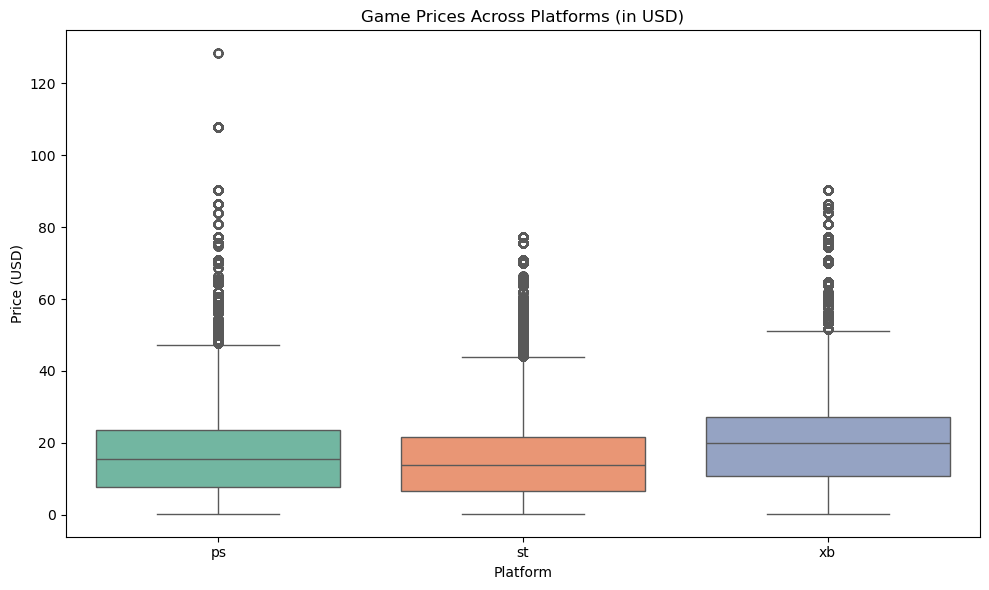

In [76]:
### Boxplot visualizing the distribution of game prices (in USD) across platforms

# Convert prices to USD
exchange_rates = {
    'eur': 1.08, 
    'gbp': 1.29, 
    'jpy': 0.0067,
    'rub': 0.012, 
    'usd': 1.0
}

tidy_game_info['price_usd'] = tidy_game_info.apply(
    lambda row: row['price'] * exchange_rates.get(row['currency'].lower(), 1.0), axis=1
)

# Visualize price distribution across platforms
plt.figure(figsize=(10, 6))
sns.boxplot(x='platform', y='price_usd', hue='platform', data=tidy_game_info, palette='Set2', legend=False)

plt.title("Game Prices Across Platforms (in USD)")
plt.xlabel("Platform")
plt.ylabel("Price (USD)")
plt.tight_layout()
plt.show()

### Number of Achievements Distribution of Shared Games Across Platforms

Interpretation:
- The number of achievements per game typically stays below 50, with a few outliers over 100.
- Games on PlayStation generally feature more achievements than games on other platforms, while games on Steam have a wider range with outliers reaching over 1000.

count    10398.000000
mean        41.527890
std         61.519762
min          0.000000
25%         19.000000
50%         31.000000
75%         50.000000
max       4820.000000
Name: achievements_per_game, dtype: float64


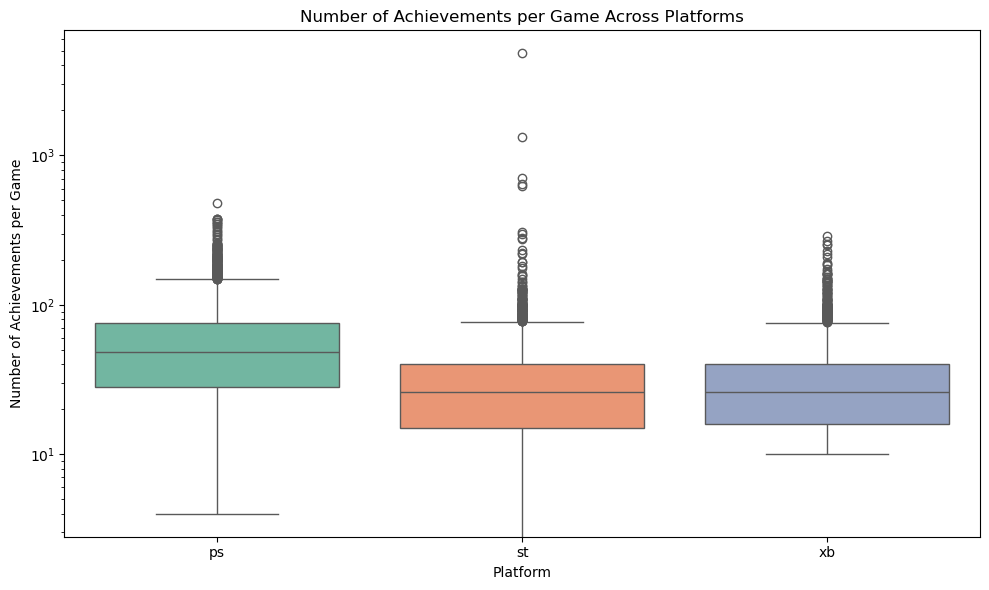

In [77]:
### Boxplot visualizing the distribution of the number of achievements per game across platform

achievements_per_game = tidy_game_info.groupby(["title", "platform"])["achievementid"].nunique().reset_index()
achievements_per_game.rename(columns={"achievementid": "achievements_per_game"}, inplace=True)

print(achievements_per_game['achievements_per_game'].describe())

plt.figure(figsize=(10, 6))
sns.boxplot(x='platform', y='achievements_per_game', hue='platform', data=achievements_per_game, palette='Set2', legend=False)

plt.title("Number of Achievements per Game Across Platforms")
plt.xlabel("Platform")
plt.ylabel("Number of Achievements per Game")
plt.yscale('log')
plt.tight_layout()
plt.show()

### Distribution of Top 10 Popular Genre Tags of Shared Games Across Platforms

Interpretation: 
- The Top 10 most commonly assigned genres for shared games across platforms are Indie, Adventure, Action, RPG, Simulation, Strategy, Platformer, Casual, Turn-Based, and Puzzle.
- Steam has the highest frequency of Top 10 genre tags assigned to shared games compared to PlayStation and Xbox, indicating that a larger proportion of games on Steam might be categorized with certain genres.

platform          ps         st        xb
genres                                   
Indie       7.111988  21.286433  5.377374
Adventure   7.651840  15.989195  9.944078
Action      3.637378  21.155339  7.477222
RPG         7.748229   7.982374  7.204869
Simulation  3.650442   7.894061  4.251958
Strategy    3.224986   6.535450  3.247911
Platformer  7.419870   0.000000  4.897708
Casual      0.308587   9.025932  0.375719
Turn Based  4.603744   0.000000  4.152657
Puzzle      4.182173   0.000000  3.135834


<Figure size 1200x800 with 0 Axes>

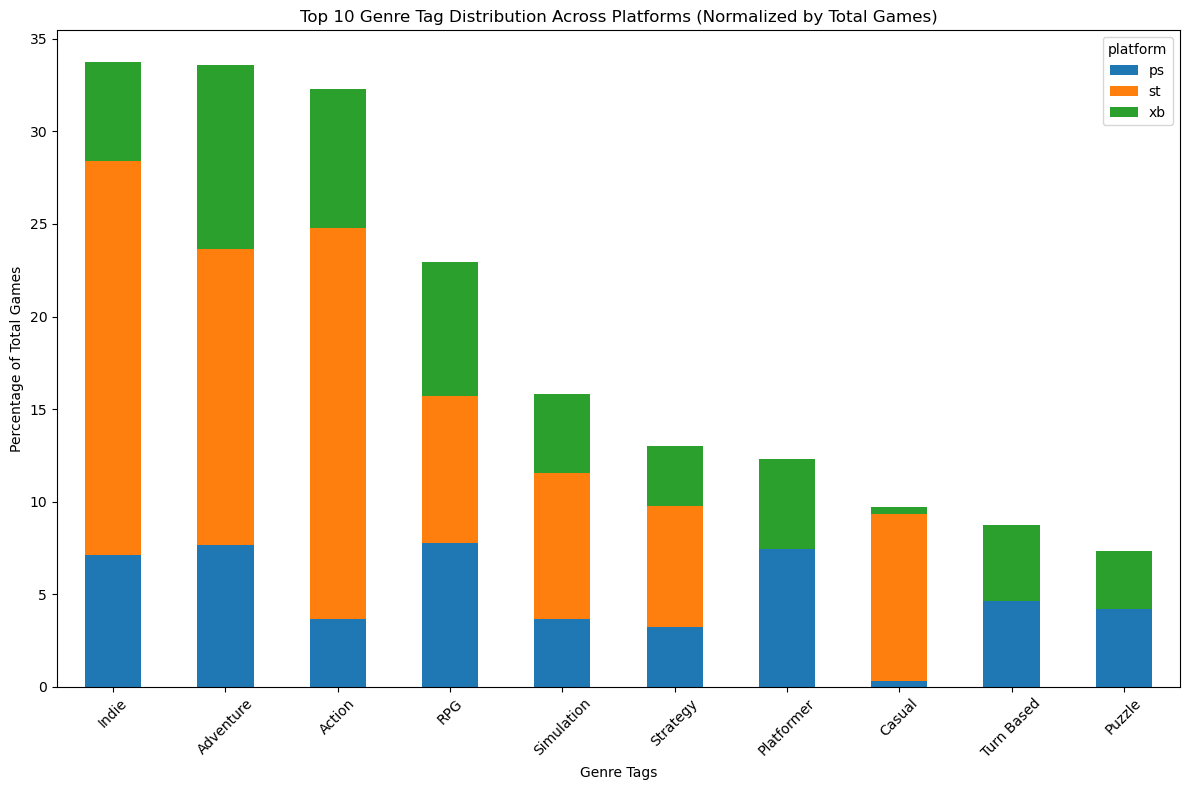

In [78]:
### Stacked barplot visualizing the distribution of the top 10 genre tags across different platforms

# Clean and explode genres into separate rows
tidy_game_info['genres'] = tidy_game_info['genres'].apply(lambda x: x.strip("[]").replace("'", '').split(', ') if isinstance(x, str) else x)
tidy_game_info = tidy_game_info.explode('genres')  

# Replace 'Role Playing' genre with 'RPG' genre
tidy_game_info['genres'] = tidy_game_info['genres'].replace({'Role Playing': 'RPG'})

# Normalize genre counts by the total number of games on each platform
total_games_per_platform = tidy_game_info['platform'].value_counts()
genre_counts_per_platform = tidy_game_info.groupby(['platform', 'genres']).size().reset_index(name='count')
genre_counts_per_platform['percentage'] = genre_counts_per_platform.apply(
    lambda row: row['count'] / total_games_per_platform[row['platform']] * 100, axis=1
)

# Select top 10 genres
top_10_genres = genre_counts_per_platform.groupby('genres')['percentage'].sum().sort_values(ascending=False).head(10).index
top_10_genre_data = genre_counts_per_platform[genre_counts_per_platform['genres'].isin(top_10_genres)]

# Pivot the data to prepare for stacking by platform with genres on the x-axis
top_10_genre_data_pivot = top_10_genre_data.pivot_table(
    index='genres', columns='platform', values='percentage', aggfunc='sum', fill_value=0
)
top_10_genre_data_pivot = top_10_genre_data_pivot.loc[top_10_genres]
print(top_10_genre_data_pivot)


plt.figure(figsize=(12, 8))
top_10_genre_data_pivot.plot(kind='bar', stacked=True, figsize=(12, 8))

plt.title('Top 10 Genre Tag Distribution Across Platforms (Normalized by Total Games)')
plt.xlabel('Genre Tags')
plt.ylabel('Percentage of Total Games')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# SI 618 WN Project Part II

## **[TODO]** Descriptive Statistics
> Provide a comprehensive summary of your combined dataset using descriptive statistics. This should include means, medians, modes, ranges, variance, and standard deviations for the relevant features of your data.  The descriptive statistics should inform your guiding questions that you developed in Part I of the project, rather than merely providing an overview of your data.  Interpret these results to draw preliminary conclusions about the data.


## Inferential statistics
Conduct appropriate _hypothesis tests_ to investigate if there are significant differences or correlations within your data.  This might involve regression analysis, ANOVA, and/or chi-squared tests.
Clearly state your null and alternative hypotheses, choose an appropriate significance level, and discuss your findings. Make sure to justify the choice of your tests.

In [79]:
for col in tidy_game_info.columns:
    unique_values = tidy_game_info[col].nunique()
    total_rows = len(tidy_game_info)
    
    print(f"{col}: {unique_values}/{total_rows} unique values")
    
    if unique_values == total_rows:
        print(f"{col} is a unique identifier\n")

gameid: 14839/3913375 unique values
title: 3466/3913375 unique values
developers: 3427/3913375 unique values
publishers: 2430/3913375 unique values
genres: 112/3913375 unique values
supported_languages: 3071/3913375 unique values
release_date: 2570/3913375 unique values
achievementid: 431807/3913375 unique values
achievement_title: 114017/3913375 unique values
achievement_description: 153785/3913375 unique values
platform: 3/3913375 unique values
currency: 5/3913375 unique values
price: 1580/3913375 unique values
price_usd: 2062/3913375 unique values


In [80]:
tidy_game_info.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3913375 entries, 0 to 2159924
Data columns (total 14 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   gameid                   int64  
 1   title                    object 
 2   developers               object 
 3   publishers               object 
 4   genres                   object 
 5   supported_languages      object 
 6   release_date             object 
 7   achievementid            object 
 8   achievement_title        object 
 9   achievement_description  object 
 10  platform                 object 
 11  currency                 object 
 12  price                    float64
 13  price_usd                float64
dtypes: float64(2), int64(1), object(11)
memory usage: 447.9+ MB


In [81]:
ps_player_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19861683 entries, 0 to 19861682
Data columns (total 10 columns):
 #   Column         Dtype  
---  ------         -----  
 0   playerid       int64  
 1   nickname       object 
 2   country        object 
 3   achievementid  object 
 4   date_acquired  object 
 5   gameid         float64
 6   title          object 
 7   description    object 
 8   rarity         object 
 9   library        object 
dtypes: float64(1), int64(1), object(8)
memory usage: 1.5+ GB


In [82]:
st_player_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11113724 entries, 0 to 11113723
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   playerid       int64  
 1   country        object 
 2   created        object 
 3   achievementid  object 
 4   date_acquired  object 
 5   gameid         float64
 6   title          object 
 7   description    object 
 8   library        object 
dtypes: float64(1), int64(1), object(7)
memory usage: 763.1+ MB


In [83]:
xb_player_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15545366 entries, 0 to 15545365
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   playerid       int64  
 1   nickname       object 
 2   achievementid  object 
 3   date_acquired  object 
 4   gameid         float64
 5   title          object 
 6   description    object 
 7   points         float64
 8   library        object 
dtypes: float64(2), int64(1), object(6)
memory usage: 1.0+ GB


### 1. Are games with more achievements associated with higher price?
Since we are only testing whether a relationship between number of achievements and price in USD exists, **Pearson’s correlation** is appropriate.
Here are the justifications:
- Both variables are continuous (necessary for Pearson’s correlation).
- We wanted to test for linear associations rather than predictive modeling (which would require regression).
- Significance level evaluation (p-value) helps determine if observed correlations are likely due to chance.

#### Null Hypothesis (H0)
There is no significant correlation between the number of achievements and game price.

#### Alternative Hypothesis (HA)
There is a significant correlation between the number of achievements and game price.


In [84]:
import statsmodels.api as sm

achievement_counts = tidy_game_info.groupby(['gameid', 'platform'])['achievementid'].count().reset_index()
achievement_counts.rename(columns={'achievementid': 'num_achievements'}, inplace=True)

game_price_data = tidy_game_info[['gameid', 'platform', 'price_usd']].drop_duplicates()
df_p_a = pd.merge(achievement_counts, game_price_data, on=['gameid', 'platform'])

In [85]:
achievement_counts

,gameid,platform,num_achievements
0,51,ps,255
1,55,ps,455
2,67,ps,245
3,81,ps,60
4,84,ps,60
...,...,...,...
14847,3135560,st,0
14848,3143880,st,1005
14849,3165620,st,555
14850,3221740,st,210


In [86]:
tidy_game_info[tidy_game_info['gameid']==51].duplicated().sum()

0

In [87]:
df_p_a.dropna(subset=['price_usd', 'num_achievements'], inplace=True)

In [88]:
from scipy.stats import pearsonr

def compute_pearson(df, platform):
    subset = df[df['platform'] == platform].dropna(subset=['num_achievements', 'price_usd'])
    
    r, p_value = pearsonr(subset['num_achievements'], subset['price_usd'])
    return platform, r, p_value

platforms = df_p_a['platform'].unique()
results = [compute_pearson(df_p_a, platform) for platform in platforms]

pearson_results = pd.DataFrame(results, columns=['Platform', 'Correlation (r)', 'p-value'])
pearson_results

,Platform,Correlation (r),p-value
0,ps,0.428426,0.000000e+00
1,xb,0.382704,0.000000e+00
2,st,0.115512,1.609254e-49


In [89]:
def interpret_pearson_results(df):

    interpretations = []
    
    for _, row in df.iterrows():
        platform = row["Platform"]
        r = row["Correlation (r)"]
        p = row["p-value"]
        
        # alpha: significance level
        if p < 0.01:
            significance = "highly significant (p < 0.01)"
        elif p < 0.05:
            significance = "significant (p < 0.05)"
        else:
            significance = "not significant (p >= 0.05)"
        
        # r: strength and direction of correlation
        r_abs = abs(r)
        if r_abs >= 0.7:
            strength = "a strong correlation"
        elif r_abs >= 0.4:
            strength = "a moderate correlation"
        elif r_abs >= 0.2:
            strength = "a weak correlation"
        else:
            strength = "no meaningful correlation"

        if r > 0:
            direction = "positive (more achievements is associated with higher price)"
        elif r < 0:
            direction = "negative (more achievements is associated with lower price)"
        else:
            direction = "no correlation at all"

        interpretation = f"On {platform} platform, there is {strength} ({direction}), and the result is {significance} (r = {r:.2f}, p = {p:.3f}).\n"
        interpretations.append(interpretation)
    
    return "\n".join(interpretations)

interpretation_text = interpret_pearson_results(pearson_results)
print(interpretation_text)

On ps platform, there is a moderate correlation (positive (more achievements is associated with higher price)), and the result is highly significant (p < 0.01) (r = 0.43, p = 0.000).

On xb platform, there is a weak correlation (positive (more achievements is associated with higher price)), and the result is highly significant (p < 0.01) (r = 0.38, p = 0.000).

On st platform, there is no meaningful correlation (positive (more achievements is associated with higher price)), and the result is highly significant (p < 0.01) (r = 0.12, p = 0.000).



#### Interpretation
- PlayStation Platform: Moderate positive correlation (r = 0.43), highly significant (p < 0.01) → Reject H_0  → More achievements are moderately associated with higher price.
- Xbox Platform: Weak positive correlation (r = 0.38), highly significant (p < 0.01) → Reject H_0  → More achievements are weakly associated with higher price.
- Steam Platform: No meaningful correlation (r = 0.12), highly significant (p < 0.01) → Reject H_0  → Although significant, the correlation is too weak to suggest a strong association.

On PlayStation and Xbox, a higher number of achievements tends to be associated with higher prices, though the relationship is stronger on PS. On Steam, while significant, the association is too weak to be practically meaningful.

### 2. PlayStation and Steam: Do players from different countries tend to complete achievements faster?
#### Test used: One-Way ANOVA
* y: achievement completion time (time_to_achievement = date_acquired - release_date).
* X: country (in merged_player_info).
* Condition: ANOVA assumes normally distributed residuals and equal variances. If these assumptions don’t hold, we may use a Kruskal-Wallis test (non-parametric alternative).

#### Null Hypothesis (H0)
There is no significant difference in achievement completion time among players from different countries.

#### Alternative Hypothesis (HA)
At least one country's players complete achievements at a significantly different speed compared to others.

#### Necessary merging for player-focus info

In [90]:
# standardizing data
ps_player_info["player_platform"] = "ps"
ps_player_info.rename(columns={"title": "achievement_title"}, inplace=True)
ps_player_info.drop(columns=["rarity", "nickname", "library"], inplace=True)

In [91]:
ps_player_info.sample(5)

,playerid,country,achievementid,date_acquired,gameid,achievement_title,description,player_platform
10652519,1922518,Netherlands,484353_4268043,2023-05-18 02:58:02,484353.0,Race Driver,Complete the TC-2 Finale,ps
363429,3065998,United Arab Emirates,571452_4753303,2023-03-31 21:41:54,571452.0,Complete level 5,Complete level 5,ps
3420226,4218774,France,165015_2823699,2018-11-14 03:01:47,165015.0,Pops of the Tops,Detonate 3 explosive chests on the pillars in ...,ps
8420834,348948,Hong Kong,12463_135393,2016-07-12 20:45:04,12463.0,Tropical Thunder,Complete all individual missions in Fort Itaipu,ps
14655040,1145122,Russian Federation,6185_77895,2014-06-21 22:25:40,6185.0,What Did You Call Me?,Kill 10 obnoxious Akuran gang members,ps


In [92]:
st_player_info["player_platform"] = "st"
st_player_info.rename(columns={"title": "achievement_title"}, inplace=True)
st_player_info.drop(columns=["created", "library"], inplace=True)

In [93]:
st_player_info.sample(5)

,playerid,country,achievementid,date_acquired,gameid,achievement_title,description,player_platform
5606814,76561198283661914,NaN,644560_LevelUp_3_6,2019-08-03 18:52:21,644560.0,Right Now III,Crush 6 advanced skill gems in one single battle,st
5082229,76561197996745990,United Kingdom,218620_trk_af_1,2017-11-20 23:20:17,218620.0,Lift With Your Legs,Complete the Aftershock job on the Hard diffic...,st
3915306,76561198280871241,Japan,705090_NEW_ACHIEVEMENT_87_8,2018-08-08 21:53:15,705090.0,Super Trivia Champion,Super Trivia Champion,st
5748180,76561198989393127,Mexico,270880_id_45th_parallel,2023-04-27 09:52:18,270880.0,45th Parallel,Visit 45th parallel in Idaho - a halfway betwe...,st
200670,76561197987596512,Brazil,767030_NEW_ACHIEVEMENT_84_26,2018-04-16 07:48:34,767030.0,Super Trivia Champion,Super Trivia Champion,st


In [94]:
xb_player_info["player_platform"] = "xb"
xb_player_info.rename(columns={"title": "achievement_title"}, inplace=True)
xb_player_info.drop(columns=["points", "nickname", "library"], inplace=True)

xb_player_info["country"] = 'Unknown'

In [95]:
xb_player_info.sample(5)

,playerid,achievementid,date_acquired,gameid,achievement_title,description,player_platform,country
8451790,1351976,12074_372371,2020-05-09 12:39:41,12074.0,Ultimate Bonfire,Reinforce a bonfire to the highest level.,xb,Unknown
6143688,844092,5720_340759,2015-02-02 05:39:00,5720.0,Slothful,Theodore defeated.,xb,Unknown
5115110,847077,1216_267619,2010-10-19 17:05:44,1216.0,"Wake Up, Buttercup",Destroyed the Corvette's engines & escort in u...,xb,Unknown
14284009,621536,1532_276656,2016-09-11 01:57:39,1532.0,Fortified Venue,Max out all guards at a venue.,xb,Unknown
14396131,627369,1434_273614,2012-06-17 06:23:08,1434.0,Go Ape Shiv,"Kill an enraged, berserk Brute by melee, any l...",xb,Unknown


In [96]:
for df, name in zip([ps_player_info, st_player_info, xb_player_info], ["PS", "ST", "XB"]):
    duplicates = df.duplicated(subset=["playerid", "gameid", "achievementid"], keep=False).sum()
    print(f"{name}: {duplicates} potential duplicate entries on (playerid, gameid, achievementid).")

PS: 0 potential duplicate entries on (playerid, gameid, achievementid).
ST: 0 potential duplicate entries on (playerid, gameid, achievementid).
XB: 0 potential duplicate entries on (playerid, gameid, achievementid).


In [97]:
columns_order = [
    "playerid", "country", "player_platform", "achievementid",
    "date_acquired", "gameid", "achievement_title", "description"
]

ps_player_info = ps_player_info[columns_order]
st_player_info = st_player_info[columns_order]
xb_player_info = xb_player_info[columns_order]

In [98]:
merged_player_info = pd.concat([ps_player_info, st_player_info, xb_player_info], ignore_index=True)

In [99]:
merged_player_info.sample(5)

,playerid,country,player_platform,achievementid,date_acquired,gameid,achievement_title,description
44177204,1905345,Unknown,xb,17708_392861,2021-12-06 22:23:23,17708.0,It wakes,Raise a character level to 10.
27874203,76561198139273871,Russian Federation,st,575640_930,2019-01-18 21:49:29,575640.0,>,Open level <
28817416,76561198132996388,Japan,st,591420_371,2017-09-24 06:35:05,591420.0,-,Open level -
26013297,76561198360357154,China,st,1235140_YAZAWA_MAIN_STORY_4,2021-05-09 15:01:42,1235140.0,Soap on a Rope,Completed Chapter 4.
38409445,831234,Unknown,xb,10761_367847,2015-11-11 12:04:13,10761.0,Sanctuary,"Complete ""Sanctuary"""


In [100]:
merged_player_info['date_acquired'] = merged_player_info['date_acquired'].str[:10]

In [101]:
merged_player_info.sample(5)

,playerid,country,player_platform,achievementid,date_acquired,gameid,achievement_title,description
14417081,1370826,United States,ps,7779_198055,2019-05-28,7779.0,Getting Started,GTA Online: Set up The Doomsday Heist.
33803089,848079,Unknown,xb,2020_291902,2018-09-14,2020.0,Team Battle (50),50 Team Battle matches won.
34416438,3939867,Unknown,xb,337686_3259923,2020-10-16,337686.0,On The Net!,You played 5 matches online.
34978518,2458861,Unknown,xb,9686_362517,2016-03-15,9686.0,Give them a Hand,Escape the Basement
4954043,368997,Italy,ps,716_5869,2012-03-21,716.0,Mailer Daemon,Access your email in 2012.


In [ ]:
# print(f"Merged dataset shape: {merged_player_info.shape}")
# print(f"Merged dataset duplicates: {merged_player_info.duplicated().sum()}")
# print(merged_player_info.info())

#### ANOVA

In [103]:
merged_player_info.sample(5)

,playerid,country,player_platform,achievementid,date_acquired,gameid,achievement_title,description
8363602,305736,United States,ps,771_33661,2012-09-28,771.0,Eagle Savior,Defeat Agandaûr without the aid of Beleram.
26975048,76561197977859730,Finland,st,760160_ACH_MAX_BLOOD,2022-05-08,760160.0,Maybe add some Fava beans and a nice chianti,Gain one of each blood resonance in a single game
43295513,3118429,Unknown,xb,5728_341199,2014-05-06,5728.0,You Know the Business,Build a MUT team with a team chemistry of 30.
4289791,3099587,Japan,ps,5016_62304,2013-08-08,5016.0,Yee Haw!,Herd the Yakows in to their Pen
13506939,297394,United States,ps,137118_210965,2020-04-05,137118.0,Troubling Consequences,Defeat Magni and Modi


In [104]:
mp_filtered = merged_player_info[['playerid', 'country', 'date_acquired', 'gameid', 'player_platform']]
tg_filtered = tidy_game_info[['gameid', 'release_date']]

In [105]:
mp_filtered['date_acquired'].sample(10)

37322929    2017-10-23
6415390     2022-12-15
10227583    2011-04-21
36089769    2011-12-27
18057406    2013-09-19
36044447    2020-12-15
38958150    2016-03-04
2067588     2010-07-19
31293387    2023-08-25
28014607    2021-06-28
Name: date_acquired, dtype: object

In [ ]:
mp_filtered = mp_filtered[mp_filtered['player_platform'].isin(['ps', 'st'])]
mp_filtered.loc[:, 'date_acquired'] = pd.to_datetime(mp_filtered['date_acquired'], errors='coerce')
tg_filtered.loc[:, 'release_date'] = pd.to_datetime(tg_filtered['release_date'], errors='coerce')

/var/folders/vr/syshz9v92js62ld8ch0rw37r0000gn/T/ipykernel_77745/94971596.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tg_filtered['release_date'] = pd.to_datetime(tg_filtered['release_date'], errors='coerce')


In [107]:
game_release_dict = tg_filtered.set_index('gameid')['release_date'].to_dict()
mp_filtered['release_date'] = mp_filtered['gameid'].map(game_release_dict)

mp_filtered['time_to_achievement'] = (mp_filtered['date_acquired'] - mp_filtered['release_date']).dt.days

# remove invalid/negative completion times
mp_filtered = mp_filtered[(mp_filtered['time_to_achievement'] >= 0) & (mp_filtered['time_to_achievement'].notna())]

# filter countries with at least 100 players for meaningful analysis
country_counts = mp_filtered['country'].value_counts()
mp_filtered = mp_filtered[mp_filtered['country'].isin(country_counts[country_counts >= 100].index)]

In [108]:
from scipy import stats

# check for normality
# sample 5000 rows for normality test (Shapiro-Wilk does not work well on very large data)
sample_df = mp_filtered.sample(n=min(5000, len(mp_filtered)), random_state=42)

stat, p = stats.shapiro(sample_df['time_to_achievement'])
print(f"Shapiro-Wilk Test: p-value = {p:.4f}")

if p < 0.05:
    print("Time-to-achievement is NOT normally distributed.")
else:
    print("Time-to-achievement appears normally distributed.")


Shapiro-Wilk Test: p-value = 0.0000
Time-to-achievement is NOT normally distributed.


In [109]:
# Levene’s test for equal variances across countries
stat, p = stats.levene(*[mp_filtered[mp_filtered['country'] == c]['time_to_achievement'] for c in mp_filtered['country'].unique()])
print(f"Levene's Test: p-value = {p:.4f}")

if p < 0.05:
    print("Variances are NOT equal (consider Welch's ANOVA).")
else:
    print("Variances are approximately equal (proceed with standard ANOVA).")


Levene’s Test: p-value = 0.0000
Variances are NOT equal (consider Welch's ANOVA).


#### Since both assumptions for ANOVA are violated (not normally distributed nor equal variance), we choose to run **Kruskal-Wallis (one-way ANOVA on ranks)** instead.

In [110]:
kruskal_result = stats.kruskal(*[mp_filtered[mp_filtered['country'] == c]['time_to_achievement'] for c in mp_filtered['country'].unique()])
print(f"Kruskal-Wallis Test: H-statistic = {kruskal_result.statistic:.4f}, p-value = {kruskal_result.pvalue:.4f}")

if kruskal_result.pvalue < 0.05:
    print("Reject H0: There is a significant difference in achievement completion time across countries (non-parametric).")
else:
    print("Fail to reject H0: No significant difference in completion time across countries.")

Kruskal-Wallis Test: H-statistic = 331601.9087, p-value = 0.0000
Reject H0: There is a significant difference in achievement completion time across countries (non-parametric).


### Interpretation of Kruskal-Wallis (one-way ANOVA on ranks) results

We conducted a **Kruskal-Wallis test**, a non-parametric alternative to ANOVA, due to violations of normality and/or equal variance assumptions.  

- H-statistic = 331601.9087, **p-value = 0.0000**  
- Since **p < 0.05**, we **reject the null hypothesis (H_0)**.  
- This result indicates a **statistically significant difference** in **achievement completion times across countries** on **PlayStation and Steam** platforms.  

### 3. [relate to graphical analysis #4] Do games with more supported languages attract more players?
We will conduct a **linear regression analysis** to determine whether the number of supported languages influences the number of players who purchased a game.
* The dependent variable (num_players_purchased) is continuous.
* The independent variable (num_supported_languages) is continuous.
* OLS regression helps quantify the strength and significance of the relationship.

#### Null Hypothesis:
The number of supported languages in a game does not significantly predict the number of players who purchased it.

#### Alternative Hypothesis:
The number of supported languages in a game significantly influences the number of players who purchased it.

In [112]:
lst = tidy_game_info['supported_languages'].sample()

In [113]:
lst.iloc[0]

"['English', 'French', 'Italian', 'German', 'Spanish - Spain', 'Korean', 'Portuguese - Brazil', 'Russian', 'Simplified Chinese', 'Spanish - Latin America', 'Traditional Chinese']"

In [114]:
import ast

game_data = tidy_game_info[['gameid', 'supported_languages']].copy()

# convert string-formatted lists to actual lists and count the number of languages
game_data['num_languages'] = game_data['supported_languages'].apply(lambda x: len(ast.literal_eval(x)) if isinstance(x, str) else 0)

# keep only numeric values
game_data.drop(columns=['supported_languages'], inplace=True)

In [115]:
game_data.sample(5)

,gameid,num_languages
508563,333483,7
2045566,1631630,1
215300,1747310,3
432288,747001,1
1736953,670303,0


In [116]:
# unique players per game
player_counts = merged_player_info.groupby('gameid')['playerid'].nunique().reset_index()
player_counts.rename(columns={'playerid': 'num_players'}, inplace=True)

df_regression = game_data.merge(player_counts, on='gameid', how='inner')

In [117]:
df_regression.sample(5)

,gameid,num_languages,num_players
1544694,407130,13,15
985885,574720,11,25
309320,1009290,11,14
352574,1253920,12,49
2984179,17249,9,508


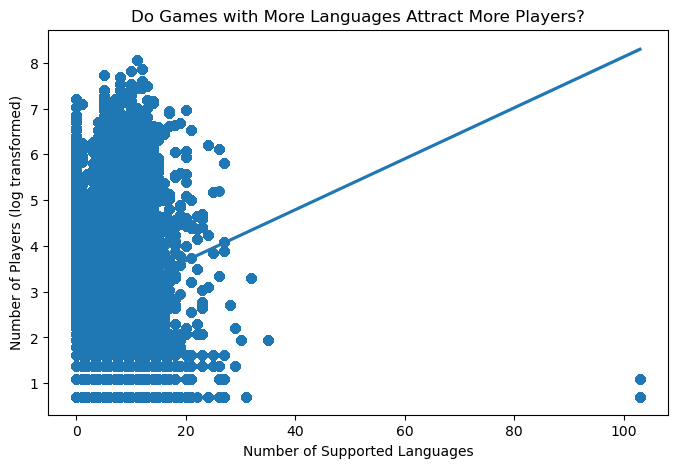

In [118]:
df_regression['log_num_players'] = np.log1p(df_regression['num_players'])


plt.figure(figsize=(8,5))
sns.regplot(x=df_regression['num_languages'], y=df_regression['log_num_players'])
plt.xlabel("Number of Supported Languages")
plt.ylabel("Number of Players (log transformed)")
plt.title("Do Games with More Languages Attract More Players?")
plt.show()

#### Since the scatterplot does not suggest a strong linear relationship between the number of supported languages and the number of players, we decided to switch to bin the number of supported languages and evaluate the binned variable and the number of players again.

/var/folders/vr/syshz9v92js62ld8ch0rw37r0000gn/T/ipykernel_77745/145610165.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_regression.groupby('language_bins')['num_players'].mean().plot(kind="bar")


<Axes: xlabel='language_bins'>

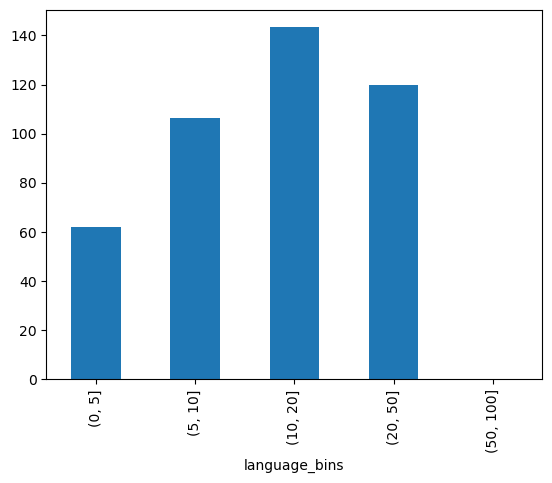

In [119]:
df_regression['language_bins'] = pd.cut(df_regression['num_languages'], bins=[0, 5, 10, 20, 50, 100])
df_regression.groupby('language_bins')['num_players'].mean().plot(kind="bar")

#### This visualization leads us to use ANOVA to test the statistical significance between bins of supported languages.

In [120]:
from scipy.stats import f_oneway

# only non-empty bins are included
groups = [df_regression[df_regression['language_bins'] == b]['num_players'].dropna() 
          for b in df_regression['language_bins'].unique() 
          if len(df_regression[df_regression['language_bins'] == b]) > 0]

if len(groups) > 1:  # at least two groups
    f_stat, p_val = f_oneway(*groups)
    print(f"ANOVA Test: F = {f_stat:.4f}, p = {p_val:.4f}")
else:
    print("ANOVA cannot be performed: Not enough non-empty groups.")


ANOVA Test: F = 10413.1380, p = 0.0000


### Interpretation of ANOVA Results: Number of Supported Languages vs. Player Count

- F-statistic = 10413.1380, **p-value = 0.0000**  
- Since **p < 0.05**, we **reject the null hypothesis (H_0)**.  
- This indicates a **statistically significant difference** in the **number of players across language support bins**.  

### 4. Do expensive vs. cheap games have different likelihoods of being cross-platform?
#### Variables and groups
* price category (high/low) vs. single vs. multi-platform.

#### Test Used: Chi-Square Test of Independence
* Both variables are categorical, and we want to test for association.

#### Null Hypothesis
There is no significant association between a game’s price category (high/low) and whether it is single-platform or multi-platform.

#### Alternative Hypothesis
There is a significant association between a game’s price category and its likelihood of being cross-platform.

In [121]:
tidy_game_info.columns

Index(['gameid', 'title', 'developers', 'publishers', 'genres',
       'supported_languages', 'release_date', 'achievementid',
       'achievement_title', 'achievement_description', 'platform', 'currency',
       'price', 'price_usd'],
      dtype='object')

In [122]:
from scipy.stats import chi2_contingency

df_price_platform = tidy_game_info[['title', 'price_usd', 'platform']].dropna(subset=['price_usd', 'platform']).drop_duplicates()

# price categories based on median price
median_price = df_price_platform['price_usd'].median()
df_price_platform['price_category'] = np.where(df_price_platform['price_usd'] <= median_price, 'Cheap', 'Expensive')

In [123]:
df_price_platform.duplicated().sum()

0

In [124]:
# classify: single-platform or cross-platform
platform_counts = df_price_platform.groupby('title')['platform'].nunique().reset_index()
platform_counts.rename(columns={'platform': 'num_platforms'}, inplace=True)

df_price_platform = df_price_platform.merge(platform_counts, on='title', how='left')

df_price_platform['platform_type'] = np.where(df_price_platform['num_platforms'] > 1, 'Multi-Platform', 'Single-Platform')

print(df_price_platform['num_platforms'].value_counts())


num_platforms
3    39144
2     1491
1      232
Name: count, dtype: int64


In [125]:
contingency_table = pd.crosstab(df_price_platform['price_category'], df_price_platform['platform_type'])

chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Test: χ² = {chi2_stat:.4f}, p-value = {p_val:.4f}")

if p_val < 0.05:
    print("Reject H0: There is a significant association between game price category and platform availability.")
else:
    print("Fail to reject H0: No significant association between game price category and platform availability.")

Chi-Square Test: χ² = 3.9091, p-value = 0.0480
Reject H0: There is a significant association between game price category and platform availability.


### Interpretation of Chi-Square Test
- χ² = 3.9091, **p = 0.0480**  
- Since **p < 0.05**, we **reject the null hypothesis (\(H_0\))**.  
- This indicates a **statistically significant association** between a game’s price category (cheap vs. expensive) and its likelihood of being cross-platform.

## Graphical analysis
Create various types of plots to visualize relationships within your data. Use histograms, bar charts, scatter plots, box plots, and any other suitable graphical representations you've learned.
Be sure to use appropriate titles, labels, and legends to make your plots readable and informative.
Interpret the graphical representations to uncover patterns, trends, and outliers.

### 1. Steam and PS: Which countries have the most **dedicated** gamers?
- measured by achievements earned per player
- visualization type: bar chart showing achievements per player by country.

In [126]:
merged_player_info.sample(5)

,playerid,country,player_platform,achievementid,date_acquired,gameid,achievement_title,description
5031155,4447023,United Arab Emirates,ps,6079_76523,2014-07-08,6079.0,Red Dragon Awaits,Defeat The Armored Dragon
2020944,1468293,Czechia,ps,703215_5666417,2024-09-18,703215.0,Strongest Shot,Reach the maximum Level for one Ranged Weapon
1070706,340983,United States,ps,14532_151409,2016-10-17,14532.0,Bridge,Complete the Bridge portion of the game
30555470,76561198060138686,Denmark,st,385770_Ace_02,2015-10-11,385770.0,Ace 2,Get 1.00K Critical Strikes
38488622,841003,Unknown,xb,1746_283920,2011-02-17,1746.0,Turret Downgrade,Activate a turret downgrade powerup


In [127]:
df_achievements = merged_player_info[['playerid', 'country', 'achievementid', 'player_platform']]

# only ps and steam have country info
df_achievements = df_achievements[df_achievements['player_platform'].isin(['ps', 'st'])]

achievements_per_player = df_achievements.groupby('playerid')['achievementid'].count().reset_index()
achievements_per_player.rename(columns={'achievementid': 'num_achievements'}, inplace=True)

In [135]:
achievements_per_player.shape

(781283, 2)

In [134]:
achievements_per_player.num_achievements.value_counts()

num_achievements
0        771445
1            85
11           24
8            22
3            21
          ...  
7693          1
1400          1
2366          1
6758          1
81209         1
Name: count, Length: 4563, dtype: int64

/var/folders/vr/syshz9v92js62ld8ch0rw37r0000gn/T/ipykernel_77745/465344115.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


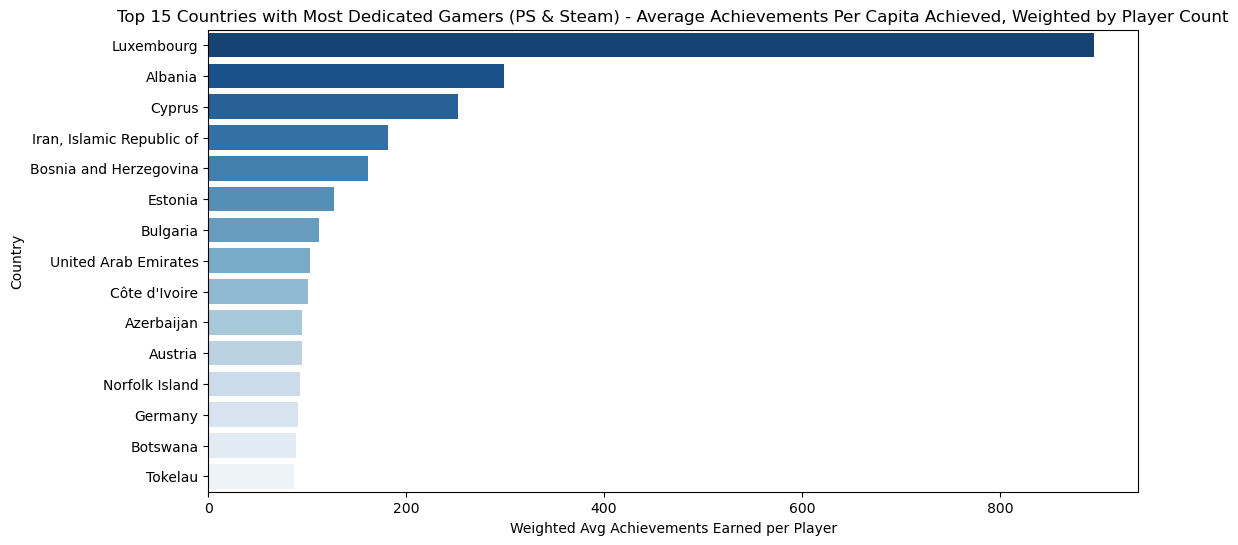

In [142]:
# weight the achievements by the number of players in that country
achievements_by_country = df_achievements.groupby('country')['achievementid'].count().reset_index()
achievements_by_country.rename(columns={'achievementid': 'total_achievements'}, inplace=True)

players_by_country = df_achievements[['playerid', 'country']].drop_duplicates().groupby('country').size().reset_index(name='num_players')

country_weighted_achievements = achievements_by_country.merge(players_by_country, on='country')

# define a smoothing factor to prevent small countries from dominating
smoothing_factor = 10

# weighted average: total achievements / (num players + smoothing factor)
country_weighted_achievements['weighted_avg_achievements'] = (
    country_weighted_achievements['total_achievements'] / 
    (country_weighted_achievements['num_players'] + smoothing_factor)
)

# sort and select top 15 countries
top_countries_weighted = country_weighted_achievements.sort_values(
    by='weighted_avg_achievements', ascending=False
).head(15)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_countries_weighted, 
    x='weighted_avg_achievements', 
    y='country', 
    palette='Blues_r'
)
plt.xlabel('Weighted Avg Achievements Earned per Player')
plt.ylabel('Country')
plt.title('Top 15 Countries with Most Dedicated Gamers (PS & Steam) - Average Achievements Per Capita Achieved, Weighted by Player Count')
plt.show()


#### Interpretation

1. **Luxembourg, Albania, and Cyprus lead the ranking**, suggesting players from these countries earn more achievements on average, even when adjusting for player count.  

2. **Smaller countries dominate the top ranks**, likely because **fewer but highly active players** skew the weighted average upwards.  

3. **Germany is the only large gaming market present**, indicating that while it has a large player base, **its most dedicated players still earn many achievements**.  

4. **Smoothing factor reduces extreme outliers**, but some smaller countries may still be overrepresented due to lower player counts.  

### 1.1 Steam and PS: For different countries, is the number of players associated with total number of achievements?

In [ ]:
achievements_by_country = df_achievements.groupby('country')['achievementid'].count().reset_index()
achievements_by_country.rename(columns={'achievementid': 'total_achievements'}, inplace=True)

players_by_country = df_achievements[['playerid', 'country']].drop_duplicates().groupby('country').size().reset_index(name='num_players')

country_achievements_vs_players = achievements_by_country.merge(players_by_country, on='country')

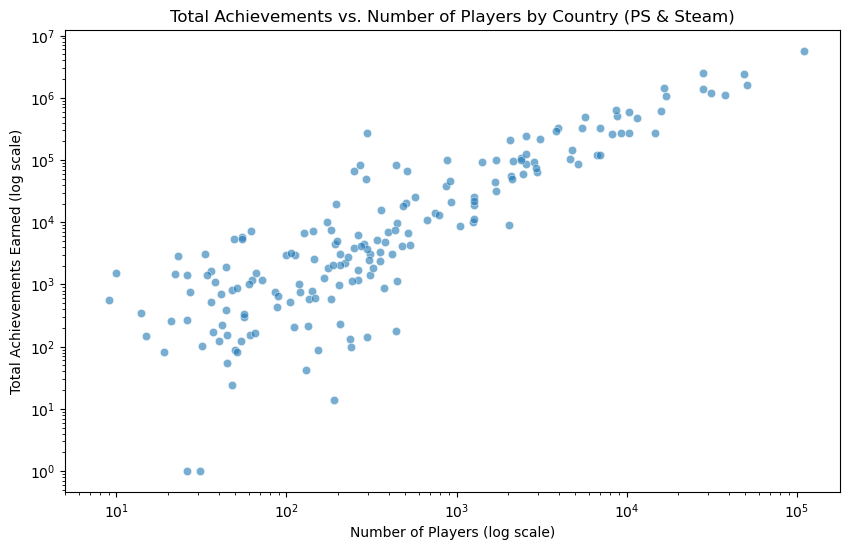

In [150]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=country_achievements_vs_players, 
    x='num_players', 
    y='total_achievements', 
    alpha=0.6
)
plt.xscale('log')  # log scale for better visualization of different-sized countries
plt.yscale('log')
plt.xlabel('Number of Players (log scale)')
plt.ylabel('Total Achievements Earned (log scale)')
plt.title('Total Achievements vs. Number of Players by Country (PS & Steam)')
plt.show()


#### Interpretation 

1. **Strong positive association**: More players in a country generally lead to more total achievements earned.  

2. Log-log scale reveals deviations: While most countries follow the trend, some have **higher or lower achievements than expected**, suggesting **differences in player engagement or gaming culture**.  

3. **Potential outliers**: Some countries with relatively few players still earn a large number of achievements, indicating **higher engagement per player** in those regions.  

### 2. How do the top 10 most **expensive** games compare in terms of player purchases and achievements?
- Another way to put: are expensive games are widely played?
- visualization type: bubble plot with price vs. number of players, sized by achievements

In [ ]:
# top 10 most expensive games per platform
top_expensive_games = tidy_game_info.groupby(['platform', 'gameid']).agg(
    max_price=('price_usd', 'max')  # Ensure we take the max price for each game
).reset_index()

top_expensive_games = top_expensive_games.sort_values(['platform', 'max_price'], ascending=[True, False])
top_expensive_games = top_expensive_games.groupby('platform').head(10)

top_expensive_games

,platform,gameid,max_price
7555,ps,744199,128.3880
421,ps,12558,108.0000
425,ps,12751,108.0000
437,ps,12965,108.0000
545,ps,14749,108.0000
591,ps,15686,108.0000
2916,ps,443601,108.0000
3071,ps,452197,90.2871
3118,ps,453429,90.2871
4341,ps,520861,90.2871


In [ ]:
# player purchase and achievements data for selected games
player_game_stats = merged_player_info.groupby(['player_platform', 'gameid']).agg(
    num_players=('playerid', 'nunique'),  # number of unique players who purchased the game
    total_achievements=('achievementid', 'count')  # total achievements earned in the game
).reset_index()
player_game_stats

,player_platform,gameid,num_players,total_achievements
0,ps,1.0,642,16112
1,ps,2.0,1429,38639
2,ps,3.0,201,908
3,ps,5.0,295,1614
4,ps,6.0,386,7995
...,...,...,...,...
46948,xb,755684.0,1,13
46949,xb,756274.0,3,48
46950,xb,756452.0,8,17
46951,xb,757317.0,3,3


In [169]:
top_expensive_stats = top_expensive_games.merge(
    player_game_stats.rename(columns={'player_platform': 'platform'}), 
    on=['platform', 'gameid'], how='left')

In [170]:
top_expensive_stats.duplicated().sum()

0

In [173]:
top_expensive_stats.dropna(inplace=True)

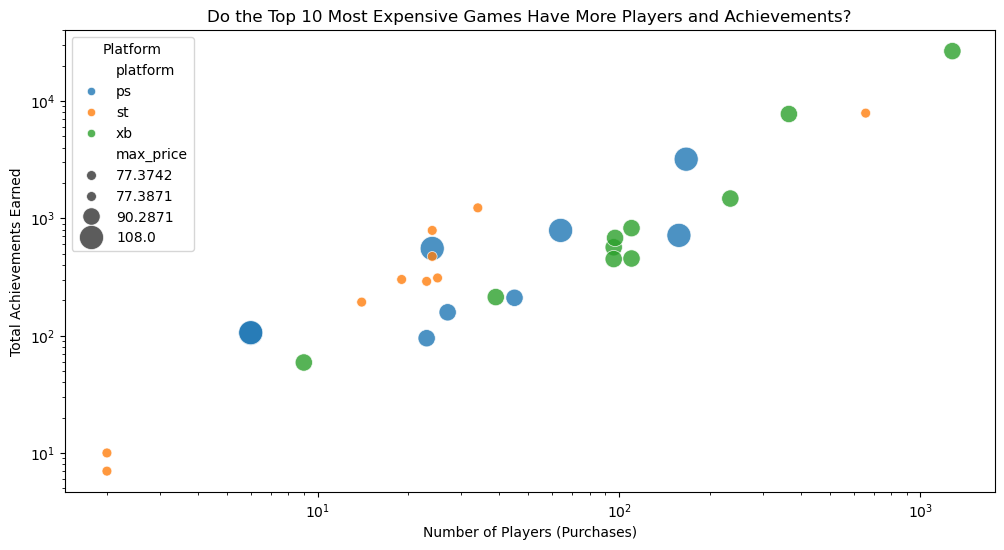

In [175]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=top_expensive_stats, 
    x='num_players', 
    y='total_achievements', 
    hue='platform', 
    size='max_price', 
    sizes=(50, 300), 
    alpha=0.8
)

plt.xlabel('Number of Players (Purchases)')
plt.ylabel('Total Achievements Earned')
plt.title('Do the Top 10 Most Expensive Games Have More Players and Achievements?')
plt.legend(title='Platform')
plt.xscale('log')  # log scale to better visualize spread
plt.yscale('log')
plt.show()

#### Interpretation

1. **Higher price ≠ more players**: Some of the most expensive games (larger bubbles) have relatively few purchases, especially on Steam (orange).  

2. Platform differences:  
   - PlayStation (blue) and Xbox (green) show higher achievement counts for expensive games with more players.  
   - Steam’s top expensive games generally have fewer players and fewer achievements.  

3. Correlation between players and achievements: Games with **more players tend to have higher total achievements**, but some outliers exist, where a game has **few players but high achievement engagement**.  

### 3. Game Ownership vs Player Dedication: How do achievement completion rates compare across platforms for the top 10 most **purchased** cross-platform games?
- visualization type: stacked bar chart for the distribution of achievement completion rates per game, grouped by platform.

In [182]:
# top 10 most purchased cross-platform games
top_purchased_games = merged_player_info.groupby(['gameid', 'player_platform']).agg(
    num_players=('playerid', 'nunique')  # unique players who own the game
).reset_index()

# cross-platform games
cross_platform_games = top_purchased_games.groupby('gameid').filter(lambda x: x['player_platform'].nunique() > 1)

top_10_purchased_games = cross_platform_games.sort_values(
    by=['player_platform', 'num_players'], ascending=[True, False]
).groupby('player_platform').head(10)  # Top 10 for each platform

top_10_purchased_games

,gameid,player_platform,num_players
25485,494230.0,ps,883
25030,487330.0,ps,818
19050,407100.0,ps,509
5472,7520.0,ps,468
6120,8850.0,ps,380
9536,18820.0,ps,348
21576,439800.0,ps,274
22314,447150.0,ps,201
4761,6120.0,ps,188
9105,17500.0,ps,143


In [193]:
# achievement completion rates for these games
achievement_completion = merged_player_info.groupby(['gameid', 'player_platform']).agg(
    total_achievements=('achievementid', 'count'),
    num_players=('playerid', 'nunique')
).reset_index()

In [194]:
achievement_completion = achievement_completion.merge(top_10_purchased_games, on=['gameid', 'player_platform', 'num_players'], how='inner')

# achievement completion rate per player 
achievement_completion['completion_rate'] = achievement_completion['total_achievements'] / achievement_completion['num_players']

In [195]:
achievement_completion

,gameid,player_platform,total_achievements,num_players,completion_rate
0,220.0,st,11265,700,16.092857
1,240.0,st,47052,950,49.528421
2,400.0,st,3965,700,5.664286
3,550.0,st,45617,2267,20.122188
4,620.0,st,24613,1438,17.116134
5,730.0,st,2915,2915,1.000000
6,1200.0,xb,19862,989,20.082912
7,1250.0,st,23033,518,44.465251
8,1520.0,xb,4459,208,21.437500
9,1530.0,xb,2745,175,15.685714


/var/folders/vr/syshz9v92js62ld8ch0rw37r0000gn/T/ipykernel_77745/626755157.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=achievement_completion, x='player_platform', y='completion_rate', palette='muted', inner='quartile')


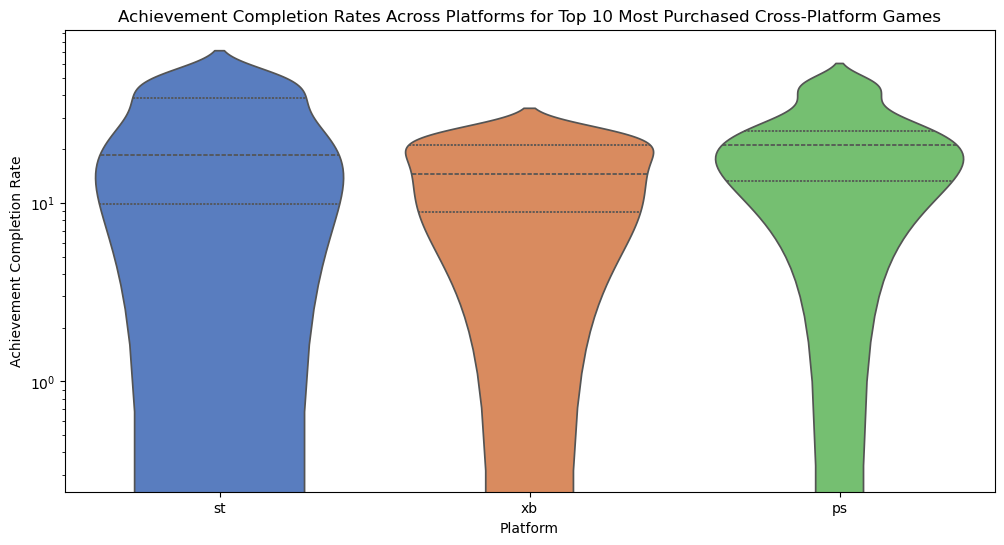

In [197]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=achievement_completion, x='player_platform', y='completion_rate', palette='muted', inner='quartile')

plt.xlabel('Platform')
plt.ylabel('Achievement Completion Rate')
plt.title('Achievement Completion Rates Across Platforms for Top 10 Most Purchased Cross-Platform Games')
plt.yscale('log')  # log scale to handle skewed distributions
plt.show()

#### Interpretation

1. Different distributions across platforms:  
   - **Steam (st) has a wider spread**, with some games having very low completion rates.  
   - **Xbox (xb) and PlayStation (ps) have more consistent distributions**, with a similar median.  

2. **Highest median on Playstation**:  
Top 10 purchased games on Playstation **tend to have slightly higher achievement completion rates** than Xbox and Steam. This suggests **players on Playstation may be more engaged in completing achievements** than players on Xbox and Steam.  

### 4. How does the number of **supported languages** vary across top 10 popular genres?
- Another way to put: Do certain genres prioritize localization more?
- visualization type: sns boxen plot for the number of supported languages grouped by genre.

In [207]:
tidy_game_info[['gameid', 'genres', 'supported_languages']].sample(5) #.duplicated().sum()

,gameid,genres,supported_languages
1836584,7410,Role-Playing Games (RPG),"['Japanese', 'French', 'Spanish', 'German', 'P..."
240836,444930,Indie,['English']
1318978,604666,"""Shoot em up""",NaN
1548625,1243830,Indie,"['English', 'French', 'Italian', 'German', 'Sp..."
1545971,857980,Strategy,"['English', 'French', 'German', 'Spanish - Spa..."


In [208]:
# each game is counted once per genre
unique_games = tidy_game_info[['gameid', 'genres', 'supported_languages']].drop_duplicates()

# the number of supported languages per game
unique_games['num_languages'] = unique_games['supported_languages'].apply(
    lambda x: len(x.strip("[]").replace("'", '').split(', ')) if isinstance(x, str) else 0
)

In [214]:
unique_games.sample(10)

,gameid,genres,supported_languages,num_languages
205215,755104,"""Shoot em up""",NaN,0
409225,558477,Sports,NaN,0
283125,649950,RPG,"['English', 'French', 'Italian', 'German', 'Sp...",12
95442,19414,strategy,"['Japanese', 'French', 'Spanish', 'German', 'I...",7
249394,872750,Adventure,['English'],1
90970,24384,Indie,['Spanish'],1
27499,583652,Action Horror,"['Japanese', 'French', 'Spanish', 'German', 'I...",12
56906,437123,Platformer,NaN,0
333613,544232,RPG,NaN,0
129654,655948,Run & Gun,"['Japanese', 'French', 'Spanish', 'German', 'K...",7


In [219]:
# top 10 most popular genres (by number of games)
top_genres = unique_games['genres'].value_counts().head(10).index

# filter only the top 10 most popular genres
top_genre_games = unique_games[unique_games['genres'].isin(top_genres)]

top_genre_games.sample(10)


,gameid,genres,supported_languages,num_languages
209230,1332720,Indie,"['English', 'French', 'Italian', 'German', 'Sp...",13
208341,1356790,Indie,"['English', 'Russian']",2
337,746946,Simulation,"['Japanese', 'French', 'Spanish', 'German', 'K...",8
185060,429927,Platformer,"['Japanese', 'French', 'Spanish', 'German', 'I...",12
259444,772750,Strategy,"['English', 'French', 'Italian', 'German', 'Sp...",8
96588,18049,Indie,"['Japanese', 'French', 'Spanish', 'German', 'K...",7
183682,435697,Strategy,"['German', 'Russian']",2
402935,606554,Platformer,NaN,0
412687,525224,Platformer,NaN,0
247088,935570,Adventure,"['English', 'French', 'German', 'Spanish - Spa...",10


/var/folders/vr/syshz9v92js62ld8ch0rw37r0000gn/T/ipykernel_77745/1288212739.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(
/var/folders/vr/syshz9v92js62ld8ch0rw37r0000gn/T/ipykernel_77745/1288212739.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Platform')


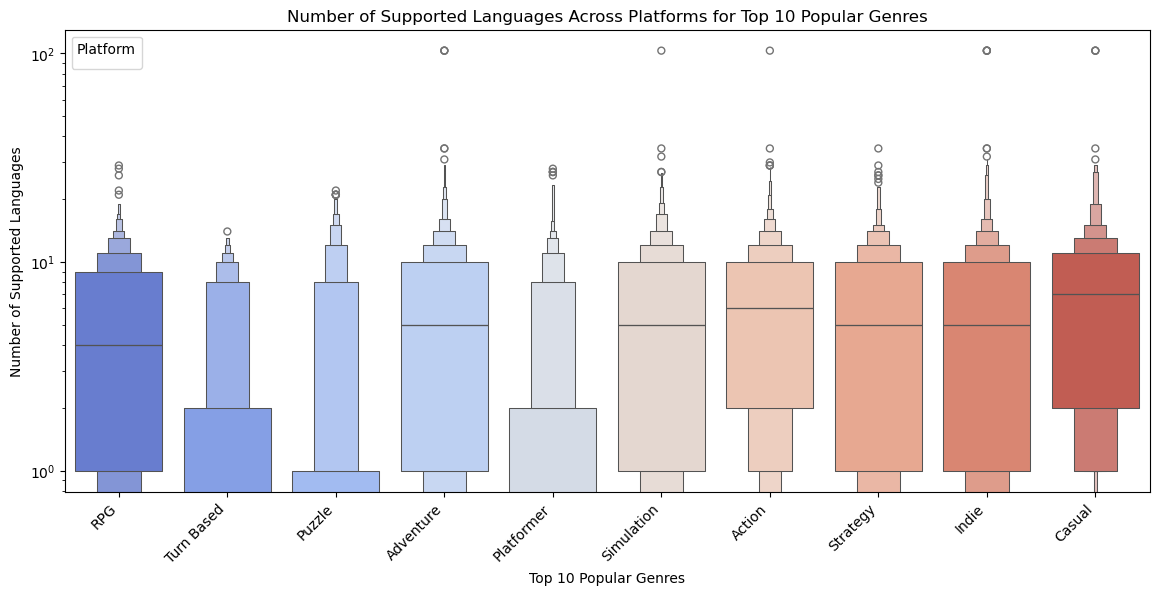

In [223]:
plt.figure(figsize=(14, 6))
sns.boxenplot(
    data=top_genre_games, 
    x='genres', 
    y='num_languages',
    palette='coolwarm'
)

plt.xlabel('Top 10 Popular Genres')
plt.ylabel('Number of Supported Languages')
plt.title('Number of Supported Languages Across Platforms for Top 10 Popular Genres')
plt.xticks(rotation=45, ha='right')
plt.yscale('log')  # log scale for better distribution visibility
plt.legend(title='Platform')

#### Interpretation 
1. **Casual and Action games tend to have higher median localization support**, suggesting these genres prioritize broader accessibility.  

2. **Puzzle, Turn-Based, and Platformer games tend to have fewer supported languages**, indicating less focus on localization, possibly due to minimal text/dialogue.  

3. **Large variability across genres**: While most genres show a broad distribution, some outliers support significantly more languages.

## Comparative Analysis
>Compare and contrast different subsets of your data. This can include comparisons over time, across different categories, or any other relevant segmentation.  Note that for some projects, the nature of this comparative analysis will be obvious.  For others, you will need to think about how you might subset your data.

In this section, we conduct a comparative analysis to explore how various aspects of gaming behavior and trends differ across platforms. By segmenting the data based on gaming platforms, we aim to uncover key differences in game ownership patterns, game popularity, release trends, and genre evolution. The primary subsets used in this analysis include:

- Platform-Based Subsets: The core comparison is across different gaming platforms, allowing us to examine how user behavior varies between them.
- Genre-Based Subsets: We analyze how different genres perform across platforms, focusing on ownership, prise, and released years.
- Temporal Subsets: For analyses related to game release periods and genre trends, we incorporate a time-based perspective to understand historical shifts in gaming preferences.

### 1. **Platform-Based Differences in Game Ownership**
- **Chosen Subset**: Players who own games on different platforms.
- **Analysis**: Compare the number of games owned across platforms.

We first count the number of games each player owns by counting the number of unique `gameid` in the `library` column of the purchased_games dataframe. 

In [224]:
import warnings
warnings.filterwarnings("ignore")
steam_library = steam_purchased_games['library'].apply(lambda x: x.count(',') + 1 if isinstance(x, str) and x != '[]' else 0)
ps_library = ps_purchased_games['library'].apply(lambda x: x.count(',') + 1 if isinstance(x, str) and x != '[]' else 0)
xbox_library = xbox_purchased_games['library'].apply(lambda x: x.count(',') + 1 if isinstance(x, str) and x != '[]' else 0)
# Combine the library sizes into a single DataFrame for better visualization
library_sizes = pd.DataFrame({
    'Platform': ['Steam'] * len(steam_library) + ['PlayStation'] * len(ps_library) + ['Xbox'] * len(xbox_library),
    'Library Size': pd.concat([steam_library, ps_library, xbox_library])
})

In [225]:
# summarize the library sizes
library_summary = library_sizes.groupby('Platform')['Library Size'].describe()
library_summary = library_summary.rename(columns={
    'count': 'Count', 
    'mean': 'Mean', 
    'std': 'Std Dev', 
    'min': 'Min', 
    '25%': '25th Percentile', 
    '50%': 'Median', 
    '75%': '75th Percentile', 
    'max': 'Max'
})
library_summary = library_summary.reset_index()
library_summary = library_summary.round(2)
print(library_summary)

      Platform     Count    Mean  Std Dev  Min  25th Percentile  Median  \
0  PlayStation   46582.0  233.86   322.17  1.0             81.0   157.0   
1        Steam  102548.0  109.79   600.47  0.0              0.0     0.0   
2         Xbox   46466.0  272.63   376.01  1.0             85.0   172.0   

   75th Percentile      Max  
0            283.0  13540.0  
1             65.0  32463.0  
2            323.0   9018.0  


Then we create a boxplot to visualize the distribution of game ownership across platforms.

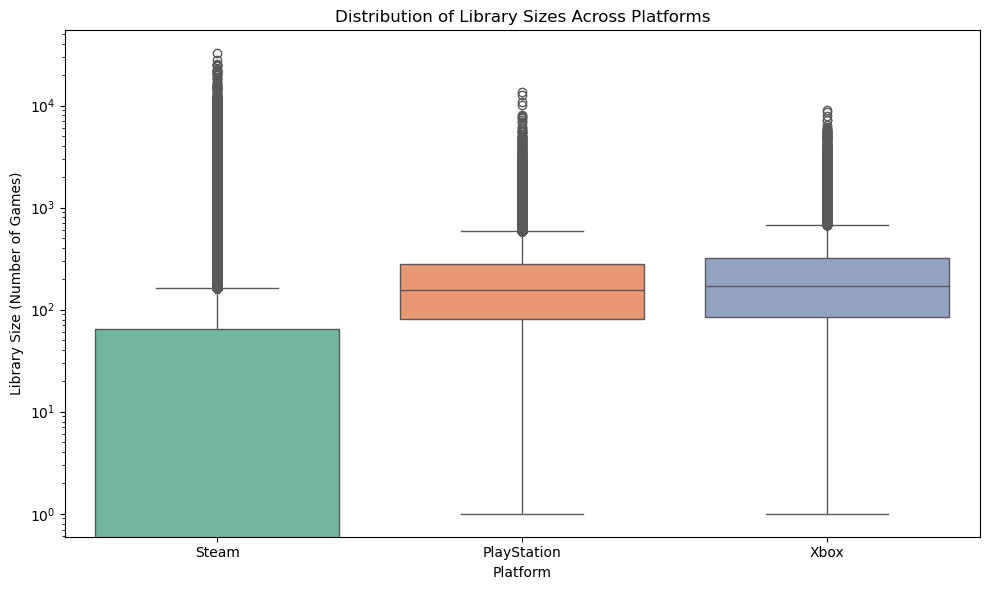

In [226]:
# Create a boxplot to visualize the distribution of library sizes across platforms
plt.figure(figsize=(10, 6))
sns.boxplot(x='Platform', y='Library Size', data=library_sizes, palette='Set2')
plt.title('Distribution of Library Sizes Across Platforms')
plt.xlabel('Platform')
plt.ylabel('Library Size (Number of Games)')
plt.yscale('log')  # log scale for better visualization
plt.tight_layout()
plt.show()

#### **Key Observations**
- **Steam** players tend to own more games on average compared to PlayStation and Xbox players.
- The distribution of game ownership is right-skewed for all platforms, indicating that a small number of players own a large number of games.

### 2. Comparations of Game Popularity Across Platforms
- **Chosen Subset**: Game popularity based on the number of players who purchased each game.
- **Analysis**: Compare the number of players for the top 500 most popular games across platforms.


In this analysis, we aim to determine the most owned games among players by extracting game IDs from their Steam libraries and merging this data with an existing dataset of Steam games.

In [227]:
from collections import Counter
import re

all_games = steam_purchased_games['library'].dropna().astype(str).apply(lambda x: re.findall(r'\d+', x))
game_counts = Counter([game for sublist in all_games for game in sublist])
steam_game_counts = pd.DataFrame(game_counts.items(), columns=['game_id', 'count'])

# Ensure both columns have the same data type before merging
steam_game_counts['game_id'] = steam_game_counts['game_id'].astype(int)
steam_games['gameid'] = steam_games['gameid'].astype(int)

# merge with steam_games to get game info
steam_game_counts = steam_game_counts.merge(steam_games, left_on='game_id', right_on='gameid', how='inner').drop(columns=['gameid'])
# sort by count
steam_game_counts = steam_game_counts.sort_values(by='count', ascending=False).reset_index(drop=True)
steam_game_counts.head(10)

,game_id,count,title,developers,publishers,genres,supported_languages,release_date
0,730,43967,Counter-Strike 2,['Valve'],['Valve'],"['Action', 'Free To Play']","['Czech', 'Danish', 'Dutch', 'English', 'Finni...",2012-08-21
1,578080,28356,PUBG: BATTLEGROUNDS,['PUBG Corporation'],"['KRAFTON, Inc.']","['Action', 'Adventure', 'Massively Multiplayer...","['English', 'Korean', 'Simplified Chinese', 'F...",2017-12-21
2,550,24727,Left 4 Dead 2,['Valve'],['Valve'],['Action'],"['Danish', 'Dutch', 'English', 'Finnish', 'Fre...",2009-11-16
3,218620,23785,PAYDAY 2,['OVERKILL - a Starbreeze Studio.'],['Starbreeze Publishing AB'],"['Action', 'RPG']","['English', 'German', 'French', 'Italian', 'Sp...",2013-08-13
4,304930,21620,Unturned,['Smartly Dressed Games'],['Smartly Dressed Games'],"['Action', 'Adventure', 'Casual', 'Indie', 'Fr...",['English'],2017-07-07
5,1172470,21197,Apex Legends™,['Respawn'],['Electronic Arts'],"['Action', 'Adventure', 'Free To Play']","['English', 'French', 'Italian', 'German', 'Sp...",2020-11-04
6,230410,18906,Warframe,['Digital Extremes'],['Digital Extremes'],"['Action', 'RPG', 'Free To Play']","['English', 'German', 'French', 'Italian', 'Ko...",2013-03-25
7,271590,17904,Grand Theft Auto V,['Rockstar North'],['Rockstar Games'],"['Action', 'Adventure']","['English', 'French', 'Italian', 'German', 'Sp...",2015-04-13
8,407530,17711,ARK: The Survival Of The Fittest,"['Studio Wildcard', 'Instinct Games', 'Efecto ...",['Studio Wildcard'],"['Action', 'Adventure', 'Indie', 'Massively Mu...","['English', 'Simplified Chinese', 'Traditional...",2017-08-29
9,4000,17676,Garry's Mod,['Facepunch Studios'],['Valve'],"['Casual', 'Indie', 'Simulation']","['English', 'French', 'Italian', 'German', 'Sp...",2006-11-29


In [228]:
all_games = ps_purchased_games['library'].dropna().astype(str).apply(lambda x: re.findall(r'\d+', x))
game_counts = Counter([game for sublist in all_games for game in sublist])
ps_game_counts = pd.DataFrame(game_counts.items(), columns=['game_id', 'count'])
# Ensure both columns have the same data type before merging
ps_game_counts['game_id'] = ps_game_counts['game_id'].astype(int)
ps_games['gameid'] = ps_games['gameid'].astype(int)
# merge with ps_games to get game info
ps_game_counts = ps_game_counts.merge(ps_games, left_on='game_id', right_on='gameid', how='inner').drop(columns=['gameid'])
# sort by count
ps_game_counts = ps_game_counts.sort_values(by='count', ascending=False).reset_index(drop=True)
ps_game_counts.head(10)

,game_id,count,title,platform,developers,publishers,genres,supported_languages,release_date
0,7779,30721,Grand Theft Auto V,PS4,['rockstar north'],['Rockstar Games'],['Action'],"['Japanese', 'French', 'Spanish', 'German', 'I...",2022-03-15
1,16508,26571,Horizon Zero Dawn,PS4,['Guerrilla Games'],['Sony Interactive Entertainment'],"['Open World', 'Action-RPG', 'Role Playing']","['Japanese', 'French', 'Spanish', 'German', 'I...",2017-02-28
2,333860,26142,Call of Duty Modern Warfare,PS4,['Infinity Ward'],['Activision'],"['Battle Royale', 'First Person Shooter']","['Japanese', 'French', 'Spanish', 'German', 'I...",2019-10-25
3,167482,25707,Red Dead Redemption 2,PS4,['Rockstar Games'],['Rockstar Games'],['Adventure'],"['Japanese', 'French', 'Spanish', 'German', 'I...",2018-10-26
4,6988,25620,The Last of Us Remastered,PS4,['Naughty Dog'],['Sony Computer Entertainment America'],"['Action', 'Adventure']","['Japanese', 'French', 'Spanish', 'German', 'I...",2014-07-29
5,163258,25183,Marvel's Spider-Man,PS4,['Insomniac Games'],['Sony Interactive Entertainment'],"['Open World', 'Stealth', ""Beat 'em up""]","['Japanese', 'French', 'Spanish', 'German', 'I...",2018-09-07
6,10403,24754,Call of Duty: Black Ops III,PS4,['Treyarch'],['Activision'],"['shooter', 'FPS']","['Japanese', 'French', 'Spanish', 'German', 'I...",2015-11-06
7,176538,23019,Apex Legends,PS4,['Respawn Entertainment'],['Electronic Arts'],"['Free to Play', 'shooter']","['Japanese', 'French', 'Spanish', 'German', 'I...",2022-03-29
8,5446,22320,The Playroom,PS4,['sony online entertainment'],['sony online entertainment'],"['Free to Play', 'Tutorial']","['Japanese', 'French', 'Spanish', 'German', 'I...",2013-11-29
9,6185,21447,inFAMOUS Second Son,PS4,['Sucker Punch'],['Sony Computer Entertainment America'],"['Action', 'Adventure']","['Japanese', 'French', 'Spanish', 'German', 'I...",2014-03-21


In [229]:
all_games = xbox_purchased_games['library'].dropna().astype(str).apply(lambda x: re.findall(r'\d+', x))
game_counts = Counter([game for sublist in all_games for game in sublist])
xb_game_counts = pd.DataFrame(game_counts.items(), columns=['game_id', 'count'])
# Ensure both columns have the same data type before merging
xb_game_counts['game_id'] = xb_game_counts['game_id'].astype(int)
xbox_games['gameid'] = xbox_games['gameid'].astype(int)
# merge with xbox_games to get game info
xb_game_counts = xb_game_counts.merge(xbox_games, left_on='game_id', right_on='gameid', how='inner').drop(columns=['gameid'])
# sort by count
xb_game_counts = xb_game_counts.sort_values(by='count', ascending=False).reset_index(drop=True)
xb_game_counts.head(10)


,game_id,count,title,developers,publishers,genres,supported_languages,release_date
0,1226,26852,Call of Duty Black Ops,['Treyarch'],['Activision'],['shooter'],"['Japanese', 'French', 'Spanish', 'German', 'I...",2011-05-03
1,1141,26806,Halo 3,['Bungie'],['Microsoft Studios'],['shooter'],"['Japanese', 'French', 'Spanish', 'German', 'I...",2007-09-25
2,1142,26768,Grand Theft Auto IV,['rockstar north'],['Rockstar Games'],"['Action', 'Adventure']","['Japanese', 'French', 'Spanish', 'German', 'I...",2009-10-13
3,1225,26077,Call of Duty: Modern Warfare 2 (2009),['Infinity Ward'],['Activision'],"['Action', 'Adventure', 'shooter']","['Japanese', 'French', 'Spanish', 'German', 'I...",2011-02-15
4,7756,24996,Grand Theft Auto V,['rockstar north'],['Rockstar Games'],"['Action', 'Adventure']","['Japanese', 'French', 'Spanish', 'German', 'I...",2022-03-15
5,18204,24899,Fortnite,['Epic Games'],['Epic Games'],"['Third Person Shooter', 'Battle Royale', 'Tow...","['Japanese', 'French', 'Spanish', 'German', 'I...",2017-07-25
6,1216,24868,Halo: Reach,['Bungie'],['Microsoft Game Studios'],['shooter'],"['Japanese', 'French', 'Spanish', 'German', 'I...",2010-09-14
7,1155,24797,Gears of War,['Epic Games Inc.'],['Microsoft Studios'],['shooter'],"['Japanese', 'French', 'Spanish', 'German', 'I...",2009-12-29
8,1220,24748,Gears of War 2,['Epic Games Inc.'],['Microsoft Game Studios'],['shooter'],"['French', 'Spanish', 'German', 'Italian', 'Ru...",2008-11-07
9,1043,24683,Hexic HD,['Carbonated Games'],['Microsoft Studios'],['puzzle'],"['Japanese', 'French', 'Spanish', 'German', 'I...",2005-11-22


#### **Key Observations**
- The most popular game on **Steam** is **Counter-Strike Global Offensive**, with a staggering 1,000,000+ players.
- On **PlayStation**, the most popular game is **Call of Duty: Modern Warfare**, with over 500,000 players.
- The most popular game on **Xbox** is **Fortnite**, with over 300,000 players.
- The popularity of games varies significantly across platforms, with rare games overlapping between platforms.

### 3. The Evolution of Popular Games: Comparing Release Peaks Across Gaming Platforms
- **Chosen Subset**: Release year distribution for the top 500 games of different platforms.
- **Analysis**: We analyze the release year distribution for the top 500 games across platforms to understand how game popularity has evolved over time.


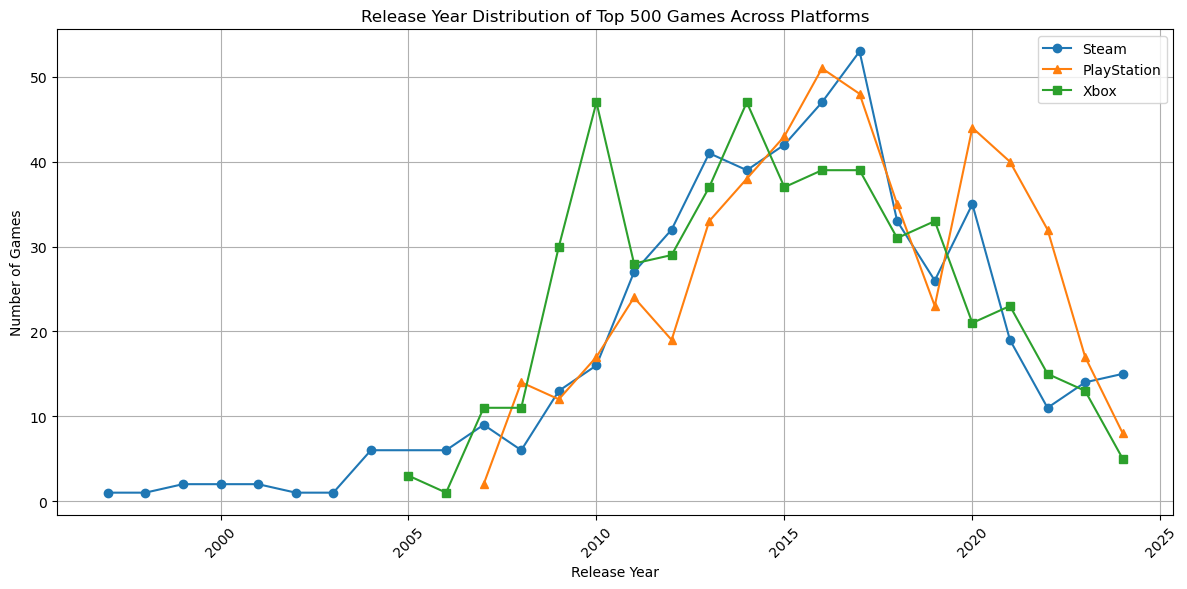

In [230]:
top_500_steam_games = steam_game_counts.head(500)
top_500_ps_games = ps_game_counts.head(500)
top_500_xb_games = xb_game_counts.head(500)

top_500_steam_games['release_year'] = pd.to_datetime(top_500_steam_games['release_date']).dt.year
top_500_ps_games['release_year'] = pd.to_datetime(top_500_ps_games['release_date']).dt.year
top_500_xb_games['release_year'] = pd.to_datetime(top_500_xb_games['release_date']).dt.year

steam_release_years = top_500_steam_games['release_year'].value_counts().sort_index()
ps_release_years = top_500_ps_games['release_year'].value_counts().sort_index()
xb_release_years = top_500_xb_games['release_year'].value_counts().sort_index()
# Display the release year distributions for the top 500 games on each platform
plt.figure(figsize=(12, 6))
plt.plot(steam_release_years.index, steam_release_years.values, label='Steam', marker='o')
plt.plot(ps_release_years.index, ps_release_years.values, label='PlayStation', marker='^')
plt.plot(xb_release_years.index, xb_release_years.values, label='Xbox', marker='s')
plt.title('Release Year Distribution of Top 500 Games Across Platforms')
plt.xlabel('Release Year')
plt.ylabel('Number of Games')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### **Key Observations**
- The **golden age** for game on all platforms appears to be around 2015, with a significant spike in the number of the most popular games released.
- For **Steam**, it contans more classical games released before 2005, which are still popular today, indicating a longer lifespan for these games.
- For **Xbox**, it shows a rapid increase in 2010, aheading the other two platforms, while dying down earlier than the others.


### 4. Shifting Trends in Game Genres: A Cross-Platform Temporal Comparison
- **Chosen Subset**: Genre distribution for the top 500 games of different platforms.
- **Analysis**: We analyze the genre distribution for the top 500 games across platforms to understand how game genres have evolved over time.

#### 4.1 **Top Game Genres Across Platforms**
This analysis aims to identify and compare the **most common genres** among the **top 500 games** for **Steam, PlayStation, and Xbox**. 

In [231]:
def extract_genres_and_years(df):
    genres_list = df['genres'].dropna().apply(lambda x: [g.strip() for g in x.strip("[]").replace("'", "").split(', ')])
    years_list = df['release_year']
    return genres_list.tolist(), years_list.tolist()

steam_genres, steam_years = extract_genres_and_years(top_500_steam_games)
ps_genres, ps_years = extract_genres_and_years(top_500_ps_games)
xb_genres, xb_years = extract_genres_and_years(top_500_xb_games)

In [232]:
# Flatten the list of lists
flattened_steam_genres = [genre for sublist in steam_genres for genre in sublist]
flattened_ps_genres = [genre for sublist in ps_genres for genre in sublist]
flattened_xb_genres = [genre for sublist in xb_genres for genre in sublist]

steam_genre_counts = Counter(flattened_steam_genres)
ps_genre_counts = Counter(flattened_ps_genres)
xb_genre_counts = Counter(flattened_xb_genres)

steam_genre_df = pd.DataFrame.from_dict(steam_genre_counts, orient='index', columns=['count']).reset_index().rename(columns={'index': 'genre'})
ps_genre_df = pd.DataFrame.from_dict(ps_genre_counts, orient='index', columns=['count']).reset_index().rename(columns={'index': 'genre'})
xb_genre_df = pd.DataFrame.from_dict(xb_genre_counts, orient='index', columns=['count']).reset_index().rename(columns={'index': 'genre'})
# Merge the genre dataframes for all platforms
merged_genre_df = steam_genre_df.merge(ps_genre_df, on='genre', how='outer', suffixes=('_steam', '_ps'))
merged_genre_df = merged_genre_df.merge(xb_genre_df, on='genre', how='outer', suffixes=('', '_xb'))
merged_genre_df.fillna(0, inplace=True)
merged_genre_df.columns = ['genre', 'count_steam', 'count_ps', 'count_xb']
# Normalize the counts to get percentages
total_counts = merged_genre_df[['count_steam', 'count_ps', 'count_xb']].sum()
merged_genre_df['percentage_steam'] = (merged_genre_df['count_steam'] / total_counts['count_steam']) * 100
merged_genre_df['percentage_ps'] = (merged_genre_df['count_ps'] / total_counts['count_ps']) * 100
merged_genre_df['percentage_xb'] = (merged_genre_df['count_xb'] / total_counts['count_xb']) * 100
# Sort the genres by total count across all platforms
merged_genre_df['total_count'] = merged_genre_df[['count_steam', 'count_ps', 'count_xb']].sum(axis=1)
merged_genre_df.sort_values(by='total_count', ascending=False, inplace=True)
# Plot the genre distribution for the top 500 games across platforms
print(merged_genre_df.head(10))

                    genre  count_steam  count_ps  count_xb  percentage_steam  \
2                  Action        360.0      67.0     206.0         27.863777   
6               Adventure        196.0      76.0     201.0         15.170279   
36                  Indie        175.0      11.0      14.0         13.544892   
82                shooter          0.0      52.0     100.0          0.000000   
51                    RPG        112.0      29.0       6.0          8.668731   
58             Simulation         80.0       8.0      28.0          6.191950   
30           Free To Play        103.0       0.0       0.0          7.972136   
63               Strategy         92.0       0.0       1.0          7.120743   
46             Open World          0.0      48.0      26.0          0.000000   
39  Massively Multiplayer         58.0       9.0       0.0          4.489164   

    percentage_ps  percentage_xb  total_count  
2        8.556833      20.355731        633.0  
6        9.706258      

Then we create a bar plot to visualize the distribution of game genres across platforms.

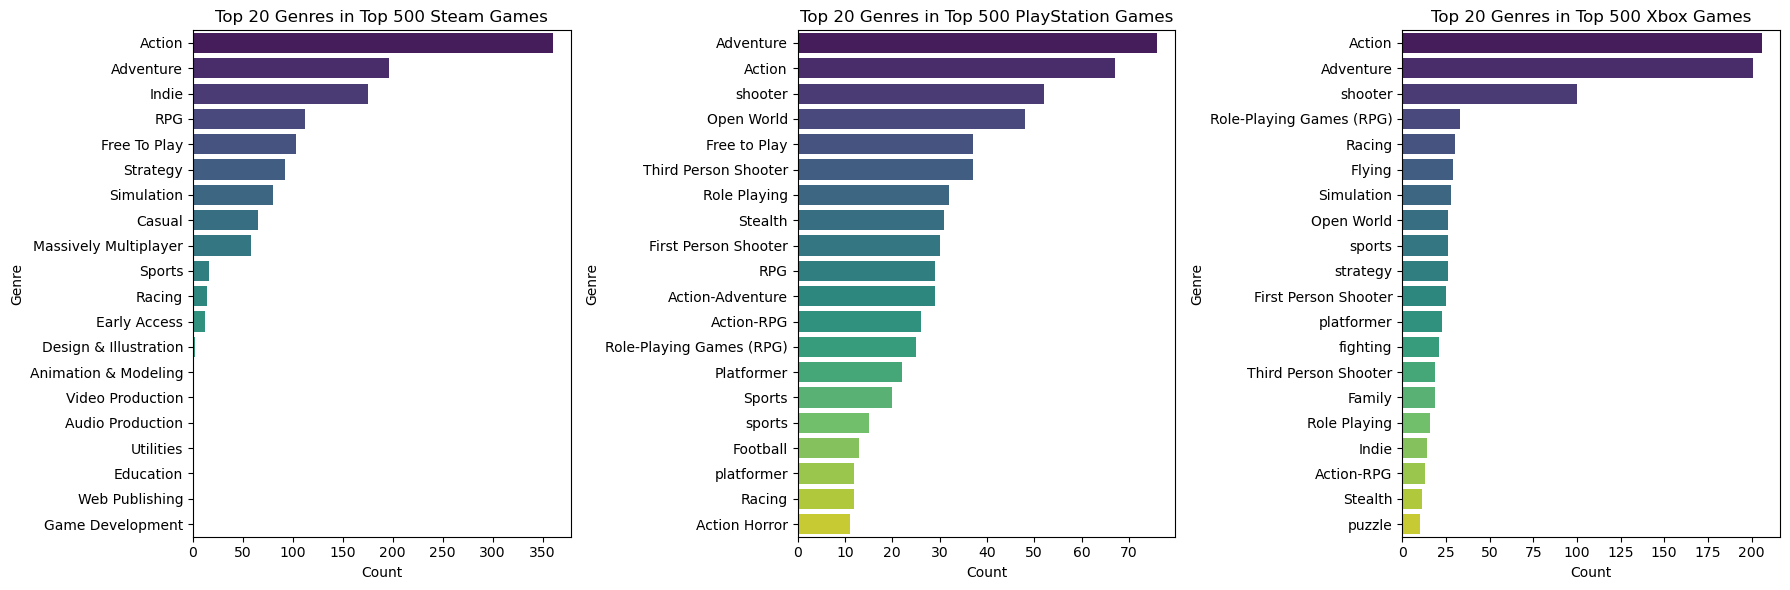

In [233]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.barplot(x='count', y='genre', data=steam_genre_df.sort_values(by='count', ascending=False).head(20), palette='viridis')
plt.title('Top 20 Genres in Top 500 Steam Games')
plt.xlabel('Count')
plt.ylabel('Genre')

plt.subplot(1, 3, 2)
sns.barplot(x='count', y='genre', data=ps_genre_df.sort_values(by='count', ascending=False).head(20), palette='viridis')
plt.title('Top 20 Genres in Top 500 PlayStation Games')
plt.xlabel('Count')
plt.ylabel('Genre')

plt.subplot(1, 3, 3)
sns.barplot(x='count', y='genre', data=xb_genre_df.sort_values(by='count', ascending=False).head(20), palette='viridis')
plt.title('Top 20 Genres in Top 500 Xbox Games')
plt.xlabel('Count')
plt.ylabel('Genre')

plt.tight_layout()
plt.show()

##### **Key Observations**
- The most common genre across all platforms is **Action**, followed by **Adventure** and **RPG**.
- **Steam** has a more diverse range of genres, with a significant number of **Indie** and **Simulation** games.
- **PlayStation** and **Xbox** have a higher concentration of **Action** and **Adventure** games, indicating a preference for these genres among their player bases.

#### 4.2 **Game Genre Trends Over Time**
In this analysis, we aim to determine how game genres have evolved over time across platforms.

In [234]:
def count_genres_by_year(genres, years):
    genre_year_counts = {}
    for genre_list, year in zip(genres, years):
        for genre in genre_list:
            if genre not in genre_year_counts:
                genre_year_counts[genre] = Counter()
            genre_year_counts[genre][year] += 1
    return genre_year_counts

steam_genre_year_counts = count_genres_by_year(steam_genres, steam_years)
ps_genre_year_counts = count_genres_by_year(ps_genres, ps_years)
xb_genre_year_counts = count_genres_by_year(xb_genres, xb_years)

def get_top_genres(genre_year_counts, top_n=5):
    total_counts = {genre: sum(year_counts.values()) for genre, year_counts in genre_year_counts.items()}
    top_genres = sorted(total_counts, key=total_counts.get, reverse=True)[:top_n]
    return top_genres

Top 5 Steam Genres: ['Action', 'Adventure', 'Indie', 'RPG', 'Free To Play']


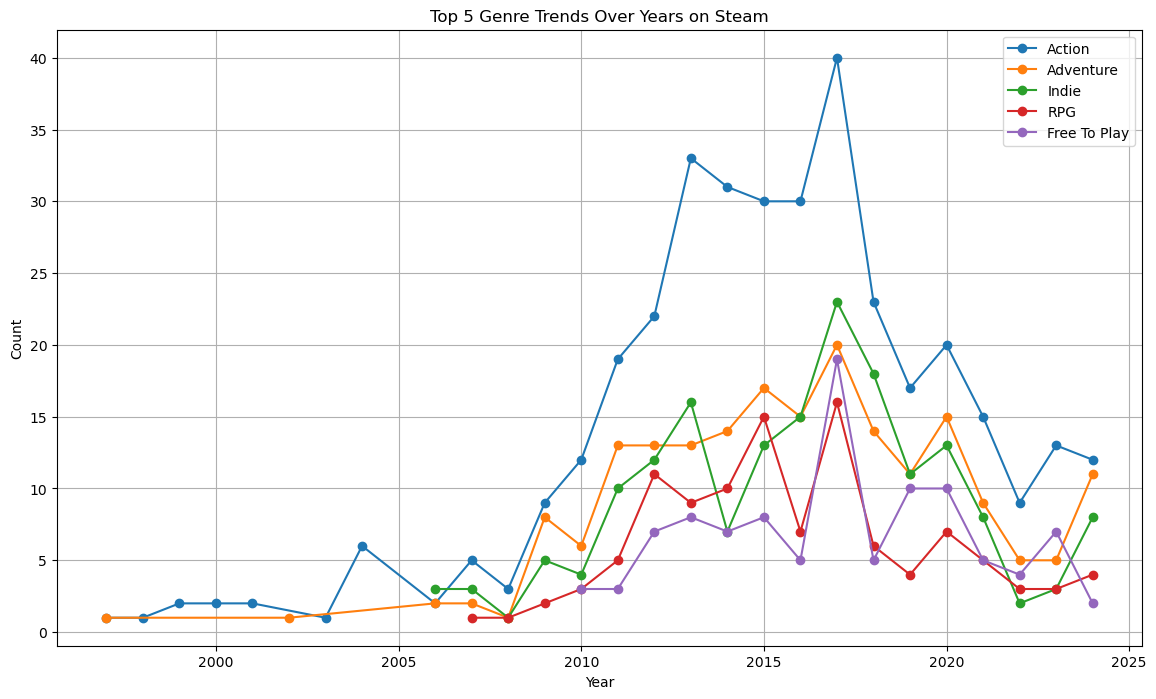

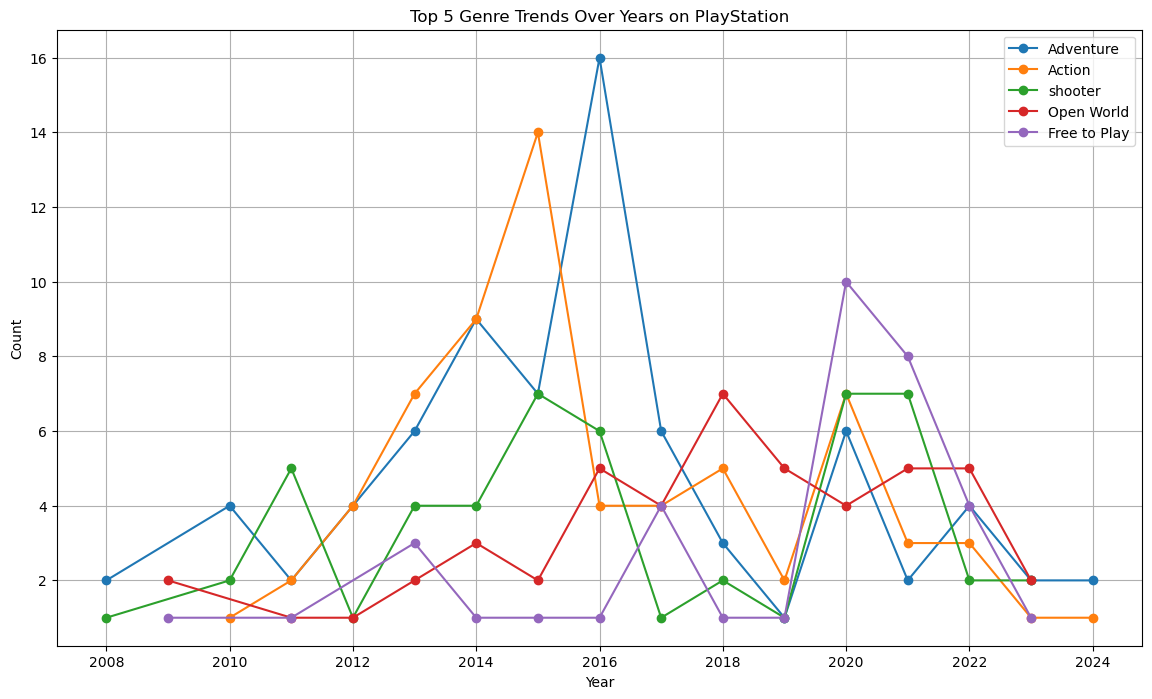

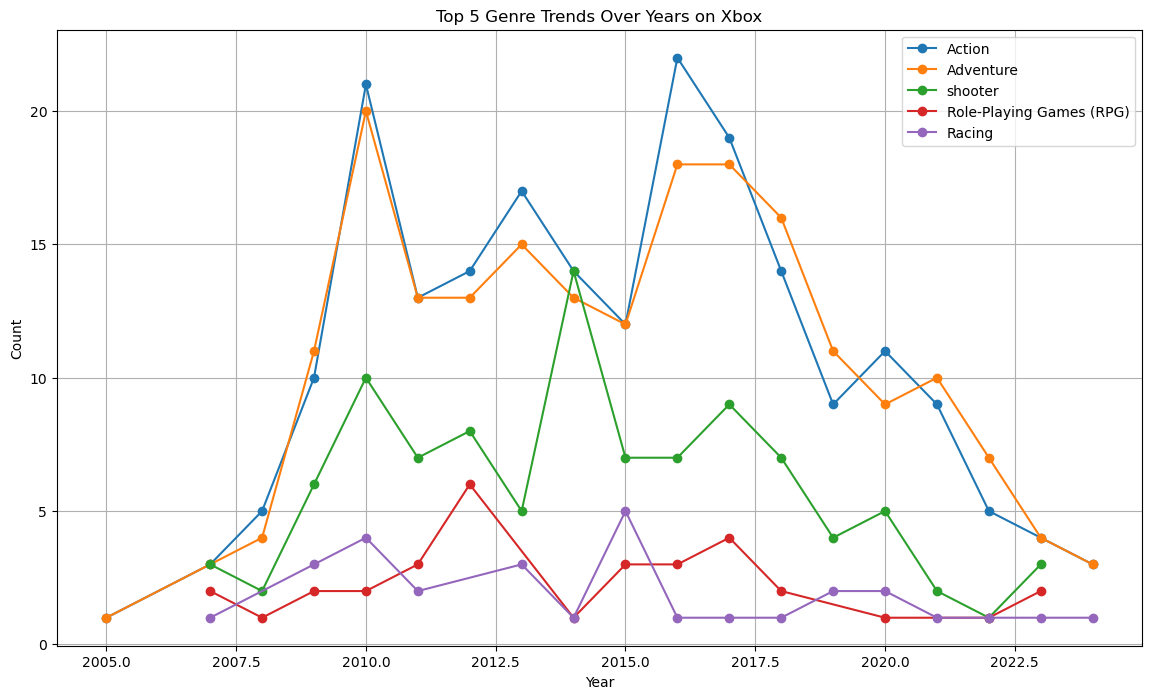

In [235]:
top_5_steam_genres = get_top_genres(steam_genre_year_counts)
top_5_ps_genres = get_top_genres(ps_genre_year_counts)
top_5_xb_genres = get_top_genres(xb_genre_year_counts)
print(f"Top 5 Steam Genres: {top_5_steam_genres}")
def plot_genre_trends(genre_year_counts, top_genres, platform_name):
    """
    Plots the trends of the top genres over years for a specific platform.

    Args:
    genre_year_counts (dict): Dictionary where keys are genres and values are year-wise counts.
    top_genres (list): List of top genres to plot.
    platform_name (str): The name of the platform.
    """
    plt.figure(figsize=(14, 8))
    
    for genre in top_genres:
        years = sorted(genre_year_counts[genre].keys())
        counts = [genre_year_counts[genre][year] for year in years]
        plt.plot(years, counts, marker='o', label=genre)
    
    plt.title(f'Top 5 Genre Trends Over Years on {platform_name}')
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot trends for each platform
plot_genre_trends(steam_genre_year_counts, top_5_steam_genres, 'Steam')
plot_genre_trends(ps_genre_year_counts, top_5_ps_genres, 'PlayStation')
plot_genre_trends(xb_genre_year_counts, top_5_xb_genres, 'Xbox')

##### **Key Observations**
- The **Action** genre has consistently remained popular across all platforms, domaining the game genre landscape over years.
- The **open-world** genre has seen a significant rise on **PlayStation** around 2015-2018, which may attribute to the success of games like **zelda: breath of the wild** and **red dead redemption 2**.
- The **Free-to-play** genre see a rapid increase on **Playstation** in 2020, which may be due to the rise of free games.

## Multivariate Analysis
> Perform multivariate analysis to understand the relationships among three or more variables in your dataset. Use techniques like cross-tabulation, pivot tables, and multivariate graphs.


### 1. Cross-Tabulation: Game developers across platforms

In [236]:
game_info = merged_game_info.copy()
game_info['developers'] = game_info['developers'].dropna().apply(lambda x: x.strip("[]").replace("'", "").split(', '))
game_info['genres'] = game_info['genres'].dropna().apply(lambda x: x.strip("[]").replace("'", "").split(', '))
game_info_exploded = game_info.explode('developers')

# Create a cross-tabulation of genres by platform
developer_platform_ct = pd.crosstab(game_info_exploded['developers'], game_info_exploded['platform'])
developer_platform_ct = developer_platform_ct.loc[(developer_platform_ct != 0).any(axis=1)]
developer_platform_ct = developer_platform_ct[developer_platform_ct.sum(axis=1) > 10]  # filter out low counts
developer_platform_ct = developer_platform_ct.sort_values(by=list(developer_platform_ct.columns), ascending=False)
print('Developer-Platform Cross Tabulation:')
print(developer_platform_ct.head(20))

Developer-Platform Cross Tabulation:
platform                        ps   st    xb
developers                                   
eastasiasoft                  7353    0  2029
ChiliDog Interactive          2341   50    50
EXE-CREATE                    2099   20  1069
Ratalaika Games               1246    0   192
Atlus                         1096    0   335
Pigeon Dev Games              1010    0   230
Alawar Entertainment           967    0   227
WayForward Technologies        961    0   273
Panda Indie Studio             909  157   174
Lillymo Games                  851  233   220
HugePixel                      849  153   182
Konami Digital Entertainment   813   49   522
Capcom Entertainment           757    0   712
Nukearts Studio                752  370   370
lightUP                        737  235   165
DuCats Games Studio            719  144   194
Kaneda Games                   700  150   150
Milestone S.r.l.               688  682   532
Tonguc Bodur                   687    0   1

#### **Key Observations**
- The **cross-tabulation** of game developers across platforms reveals that certain developers are more prevalent on specific platforms.
- For example, **ChiliDog Interactive** is primarily associated with **PlayStation**.

### 2. Pivot Table: Average Game Price by Genre and Platform

Average Price by Genre and Platform(USD):
platform           ps         st         xb
genres                                     
Action      14.240554  19.642034  19.141640
Adventure   17.586675  19.590437  20.812882
Casual      17.769204  12.807887  19.073333
Gore        29.990000   5.517778  29.990000
Indie       12.201990  14.809120  14.412194
RPG         22.899843  22.255956  22.847953
Racing      12.690000  21.499112  14.742086
Simulation  21.750932  20.960341  21.912924
Sports      26.017805  23.773565  33.922105
Strategy    24.371517  20.827776  27.668838


<Figure size 1200x600 with 0 Axes>

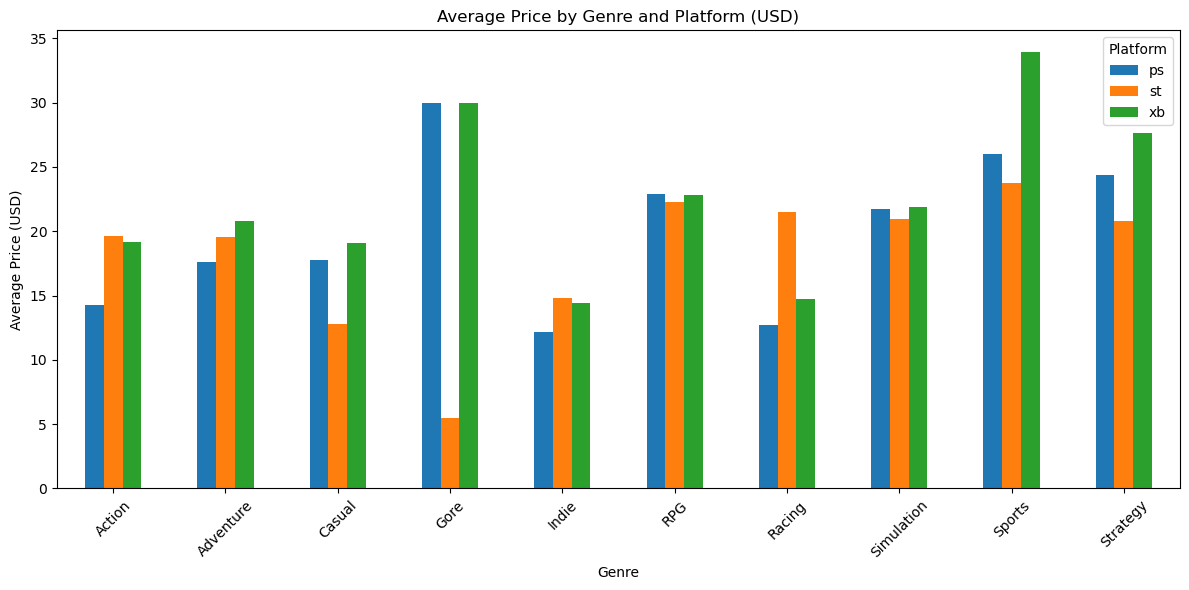

In [237]:

game_info_exploded = game_info.explode('genres')
price_pivot = game_info_exploded.pivot_table(index='genres', columns='platform', values='usd', aggfunc='mean').dropna()
print('Average Price by Genre and Platform(USD):')
print(price_pivot.head(10))
# Plot the average price by genre and platform
plt.figure(figsize=(12, 6))
price_pivot.head(10).plot(kind='bar', figsize=(12, 6))
plt.title('Average Price by Genre and Platform (USD)')
plt.xlabel('Genre')
plt.ylabel('Average Price (USD)')
plt.xticks(rotation=45)
plt.legend(title='Platform')
plt.tight_layout()
plt.show()

#### **Key Observations**
- The **pivot table** and the bar plot show that certain genres tend to be more expensive on specific platforms.
- For instance, **RPG** games are generally more expensive on **PlayStation** compared to **Steam** and **Xbox**.

### 3. Multivariate Graph: Game Popularity by Genre, Prise, and Release Year

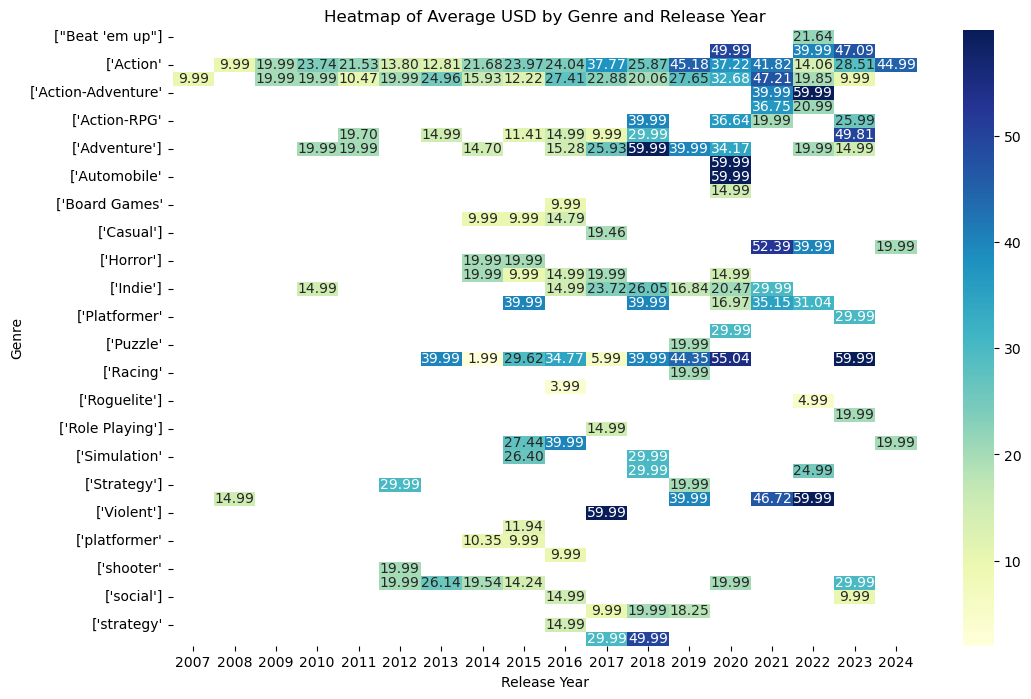

In [238]:
# Combine top 500 games data from all platforms
top_500_games = pd.concat([top_500_ps_games, top_500_steam_games, top_500_xb_games])

# Explode genres to have one genre per row
top_500_games_exploded = top_500_games.explode('genres')
top_500_games_usd = game_info[game_info['gameid'].isin(top_500_games_exploded['game_id'])][['gameid', 'usd']]

top_500_games_exploded['num_supported_languages'] = top_500_games_exploded['supported_languages'].apply(lambda x: x.count(';') + 1 if isinstance(x, str) and x != '' else 0)


top_500_games_exploded['genres'] = top_500_games_exploded['genres'].apply(lambda x: x.split(',')[0] if isinstance(x, str) else x)
top_500_games_data = top_500_games_exploded.merge(top_500_games_usd, left_on='game_id', right_on='gameid', how='left')
top_500_games_data = top_500_games_data[['title', 'count', 'release_year', 'num_supported_languages', 'genres', 'usd']]

heatmap_data = top_500_games_data.pivot_table(index='genres', columns='release_year', values='usd', aggfunc='mean')

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Heatmap of Average USD by Genre and Release Year')
plt.xlabel('Release Year')
plt.ylabel('Genre')
plt.show()

#### **Key Observations**
- Games with more popular genres tend to have higher prices, such as **Action**,**Adventure**, and **Automobile**.
- Games released in the last few years (2018-2022) tend to be more expensive.